<br>

<img src="./images/Logos.jpg" title="Institutional Logos" width="70%">


# Tropical Nights | 1993 - 2024: Integration Test of CLIMADA Impact Assessment with Copernicus Climate Change Service (C3S) data (V1)

### About

As part of the U-CLIMADAPT project's focus on climate impact assessments, this Jupyter Notebook delves into the analysis of "tropical nights" — a phenomenon characterized by exceedingly warm nighttime temperatures, which fail to drop below 20°C (68°F). These nights are more than just sleep disruptors; they signify shifts in climate patterns and pose health risks, especially to vulnerable populations.

Understanding the frequency and distribution of tropical nights is crucial for developing adaptation strategies. This tutorial employs hindcast data from 1993 to 2016, which are historical simulations used for model validation. Given the extensive size of hindcast datasets, we present precalculated results for convenience. However, for advances users who prefer hands-on analysis can run the provided tropical_nights.py script to access access and stimate tropical nights.

Following the historical analysis, we transition to examining the exposure of populations to tropical nights. The focus is narrowed to the years 1993 to 2024, and the examination is limited to data from the initial lag months. This provides a clear context for understanding the data and trends, enabling users to apply this understanding to perform more nuanced forecasting analyses in the following tutorial.

### About U-CLIMADAPT

The U-CLIMADAPT project is a collaborative effort led by the Working Group "Impact of Climate Change." Its primary goal is to provide refined climate impact assessments tailored to specific requirements. To achieve this, it leverages the power of climate forecasts and projections from C3S's Climate Data Store (CDS), while also integrating Copernicus land-use and satellite data

### Tutorial Overview

Now, let's dive into the tutorial itself. We will guide you through the following steps:

- Search, download, and visualize the relevant data from the Climate Data Store.
- Set up the hazard, specifically focusing on heat stress.
- Estimate the exposure to heat stress in your chosen area.
- Define vulnerability and calculate the potential damage.

By following this tutorial, you will gain hands-on experience and unlock the potential of integrating CLIMADA with C3S data from Copernicus. Let's get started!

<br>

### Acknowledgments

- **Script Author**: [Dahyann Araya](https://github.com/DahyannAraya?tab=repositories)
- **Reviewer**: [Timo Schmid](https://github.com/timschmi95)

## Search, download and view Copernicus data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API

To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [1]:
#!pip install cdsapi

### If this pip does not work

#### Window
Please follow the instructions for the Windows installation provided at https://bit.ly/3I6va4D. 
Please note that the Windows installation process requires you to be registered with Copernicus and have a personal key (refer to http://cds.climate.copernicus.eu for more information). Additionally, you will need to create a text document in the installation folder of the API and name it ".cdsapirc.txt". Inside the document, paste the following information:

- url: https://cds.climate.copernicus.eu/api/v2
- key: ####################################### 

After saving the content, the document will be named .cdsapirc.txt. Rename the file by removing ".txt" extension.
Once this step is completed, install in the command prompt with "$ pip install cdsapi".

To summarize, the instructions are:

- Follow the installation instructions for cdsapi on Windows at https://bit.ly/3I6va4D.
- Create a text document in the installation folder and name it ".cdsapirc".
- Within the document, paste the provided information and save it.
- Rename the document by removing the ".txt" extension.
- Install cdsapi in the command prompt with "$ pip install cdsapi".


#### macOS
To install CDS API on a Mac, please follow the instructions at https://bit.ly/3LTOgfn.

Note that the installation on Mac requires creating a document with the Terminal where you will install the API. You can do this by typing "touch ~/.cdsapirc" in the Terminal. Then, open the document by typing "nano ~/.cdsapirc" and paste the following information into the document:

- url: https://cds.climate.copernicus.eu/api/v2
- key: #######################################

After saving the content of the document, install the CDS API in the Terminal by typing "pip install cdsapi".

- Follow the instructions on this website: https://bit.ly/3I6va4D to install cdsapi on a Mac.
- Navigate to the directory where you want to install the API by using the 'cd' command in Terminal.
- Type the command 'touch ~/.cdsapirc' in Terminal to create a file for the API key.
- Type the command 'nano ~/.cdsapirc' in Terminal to open the file in a text editor.
- Within the document, paste the provided information and save it.
- Save the file by pressing 'Ctrl + X' and then 'Y'.
- Type the command 'pip install cdsapi' in Terminal to install the cdsapi module.

### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.predicates")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.constructive")

# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualizing data
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime

# Libraries for working with geospatial data
import pandas as pd
import geopandas as gpd

In [2]:
import os
# DATADIR = "/Users/daraya/Documents/test_data/data/" # create a file to save the data
DATADIR = "D:/CDS_seasonal_forecast/test_data/data"

os.makedirs(DATADIR, exist_ok=True)

### Inspect Hincast data 1993-2016


Here, two files are provided with historical data on tropical nights, each offering distinct compilations of data:

- **"combined_tropical_nights_hincast_stats.nc"**: This file provides data representing an historical year and contains statistical data for just the 12 months within that year. It includes monthly mean, median, maximum, minimum, standard deviation, and ensemble percentiles (5th, 25th, 50th, 75th, 95th) derived from 1993 to 2016 across all members. The data types for maximum and minimum values are integers, while all other statistics are floating-point numbers.

- **"combined_tropical_nights_stats.nc"**: In contrast, this file encompasses a broader dataset, containing monthly aggregated statistics of the members from each month between 1993 and 2016. It similarly includes monthly mean, median, maximum, minimum, standard deviation, and ensemble percentiles (5th, 25th, 50th, 75th, 95th).

The key difference lies in the temporal coverage of the datasets: the first file condenses the data into a single typical year, whereas the second file spans multiple years, providing a monthly breakdown over 24 years. In contrast to the first notebook, here we analyze the second **"combined_tropical_nights_stats"**.

In [3]:
# Hincast montly statistics
SCRIPT_DIR = os.getcwd() # get the current working directory
INPUTDIR = f"{SCRIPT_DIR}/data/U_CLIMADAPT_02_1993_2024_TR/inputs"
nc_file = f"{INPUTDIR}/combined_tropical_nights_hincast_stats.nc"

Here, we present the statistics for the selected reference months during the hincast period, specifically detailing data from January through September over the years 1993 to 2016. To observe trends for specific months, one can select the desired timeframe from the dataset.

It is crucial to understand that the year 2000 is used as a baseline solely for temporal alignment in the NetCDF file; this is to satisfy the file's requirement for a numerical year alongside the months. However, the year 2000 is merely a placeholder and does not represent the actual year of the data.

In [4]:
ds = xr.open_dataset(nc_file)
ds

<xarray.Dataset> Size: 63MB
Dimensions:         (latitude: 181, longitude: 360, time: 12)
Coordinates:
    surface         float64 8B ...
  * latitude        (latitude) float64 1kB 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
  * longitude       (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
    percentile      float64 8B ...
  * time            (time) datetime64[ns] 96B 2000-01-01 ... 2000-12-01
Data variables:
    monthly_mean    (time, latitude, longitude) float64 6MB ...
    monthly_median  (time, latitude, longitude) float64 6MB ...
    monthly_max     (time, latitude, longitude) int64 6MB ...
    monthly_min     (time, latitude, longitude) int64 6MB ...
    monthly_std     (time, latitude, longitude) float64 6MB ...
    ensemble_p5     (time, latitude, longitude) float64 6MB ...
    ensemble_p25    (time, latitude, longitude) float64 6MB ...
    ensemble_p50    (time, latitude, longitude) float64 6MB ...
    ensemble_p75    (time, latitude, longitude) float64 6MB ...
    ensemble_p95    (time, latitude, longitude) float64 6MB ...

In [5]:
# Extract variable
TN_eu_hincast_mean = ds['monthly_mean']

In [6]:
# Shape and sizes
print(TN_eu_hincast_mean.shape)
print(TN_eu_hincast_mean.size)

(12, 181, 360)
781920


#### Plot data

Now we will see how we can get a better understanding of the data by visualising a specific time step. With the help of Cartopy and Matplotlib, we will create a cartographic chart. By setting the Plate Carrée projection, we ensure an accurate geographical representation. Next, we create a figure with axes to prepare the graph. Using the isel() function, we will select the desired time step and plot it using the built-in plot() function provided by xarray. To provide additional context, we will add coastlines and grids to the graph. Finally, we will display the plot, allowing us to explore and analyse the data effectively.

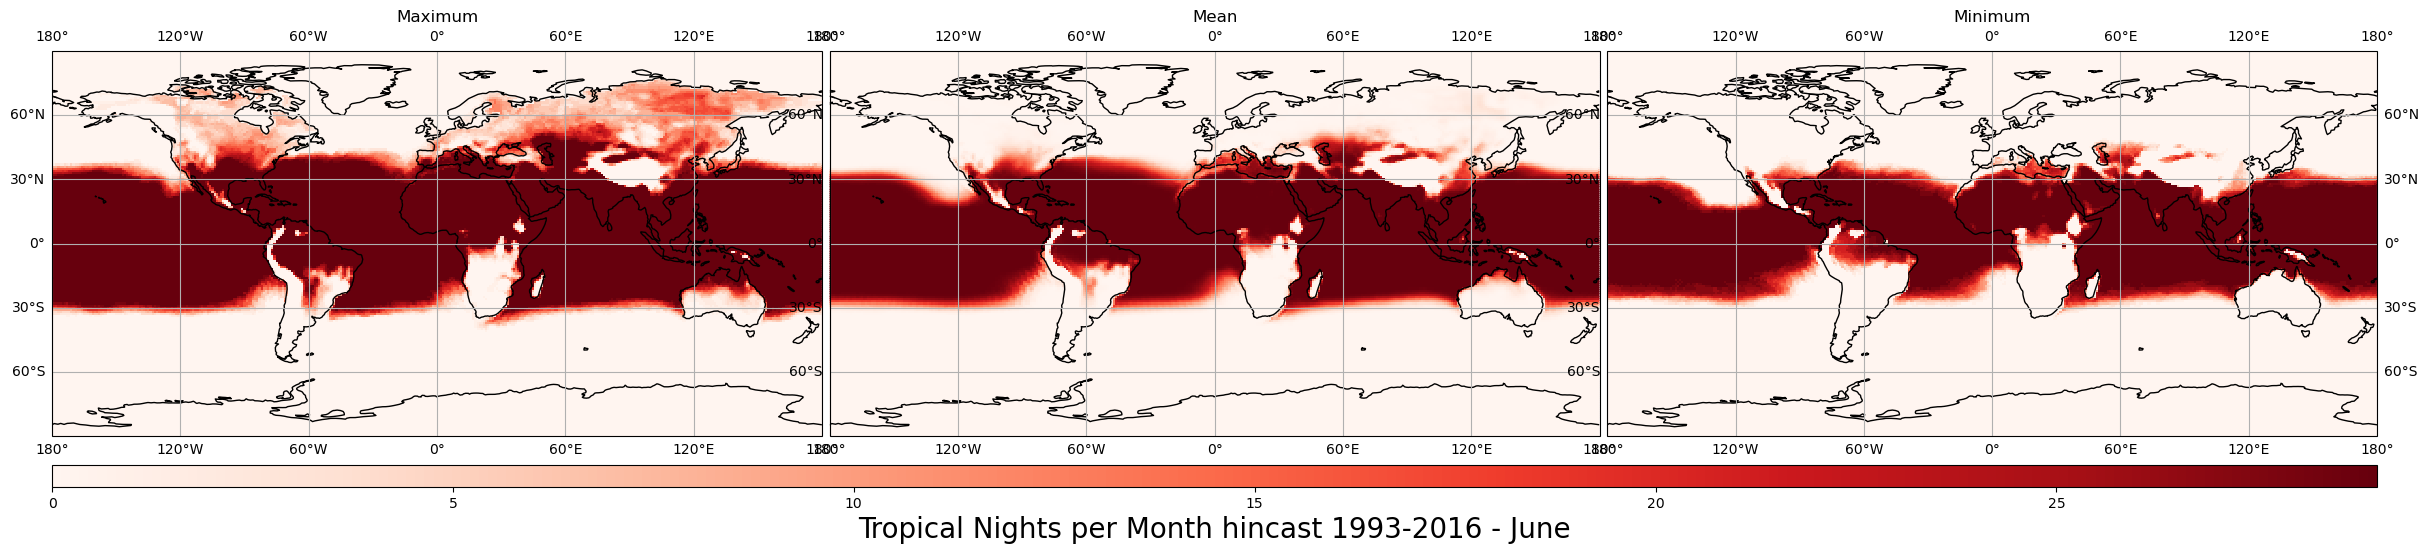

In [7]:
# Statistics
TN_eu_hincast_max = ds["monthly_max"]
TN_eu_hincast_mean = ds["monthly_mean"]
TN_eu_hincast_min = ds["monthly_min"]

proj = ccrs.PlateCarree()

# Plot properties
fig = plt.figure(figsize=(30, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], width_ratios=[1, 1, 1], hspace=0.01, wspace=0.01)
ax1 = plt.subplot(gs[0, 0], projection=proj)
ax2 = plt.subplot(gs[0, 1], projection=proj)
ax3 = plt.subplot(gs[0, 2], projection=proj)
# Place the colorbar axes closer to the plots
cax = plt.subplot(gs[1, :])

# List of axes for easy iteration
axs = [ax1, ax2, ax3]

# Titles for each subplot
titles = ["Maximum", "Mean", "Minimum"]

# Data to plot
data_to_plot = [TN_eu_hincast_max, TN_eu_hincast_mean, TN_eu_hincast_min]

# Store the images for later use in the colorbar
images = []

# Plot each data set
for ax, data, title in zip(axs, data_to_plot, titles):
    # Select the data for a specific time step
    selected_time_data = data.sel(time="2000-06-01") # June
    
    # Plot the data, saving the result to use its colorbar
    img = selected_time_data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds", add_colorbar=False)
    images.append(img)
    
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    
    # Set title
    ax.set_title(title)

# Add one colorbar at the bottom, use the first image to infer the colorbar
plt.colorbar(images[0], cax=cax, orientation="horizontal")
cax.set_xlabel("Tropical Nights per Month hincast 1993-2016 - June", size=20)  # Adjust as needed
plt.show()

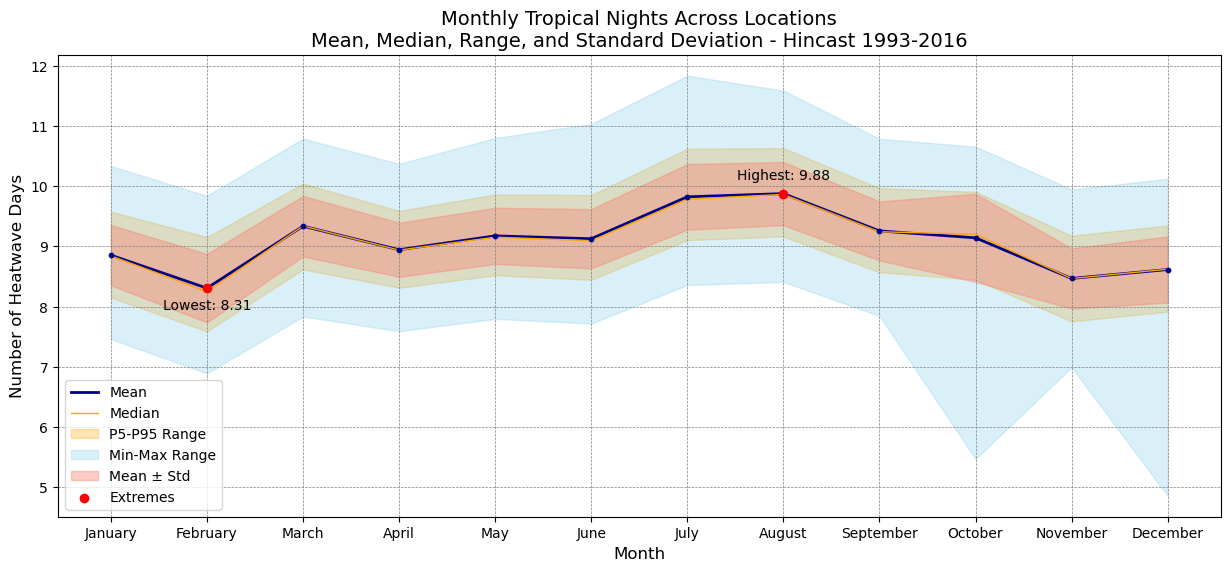

In [8]:
# Calculate the mean values across the latitude and longitude dimensions for various statistics
monthly_mean = ds['monthly_mean'].mean(dim=['latitude', 'longitude'])
monthly_median = ds['monthly_median'].mean(dim=['latitude', 'longitude'])
monthly_max = ds['monthly_max'].mean(dim=['latitude', 'longitude'])
monthly_min = ds['monthly_min'].mean(dim=['latitude', 'longitude'])
monthly_std = ds['monthly_std'].mean(dim=['latitude', 'longitude'])
monthly_p95 = ds['ensemble_p95'].mean(dim=['latitude', 'longitude'])
monthly_p5 = ds['ensemble_p5'].mean(dim=['latitude', 'longitude'])

# Convert to pandas DataFrame for easier plotting
df = pd.DataFrame({
    'Mean': monthly_mean.values,
    'Median': monthly_median.values,
    'Max': monthly_max.values,
    'Min': monthly_min.values,
    'Std': monthly_std.values,
    'P95': monthly_p95.values,
    'P5': monthly_p5.values,
}, index=pd.to_datetime(monthly_mean['time'].values))

# Adjust the index to have month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df.index = [month_names[i.month - 1] for i in df.index]

# Plotting
plt.figure(figsize=(15, 6))

# Plot the mean with more prominence
plt.plot(df.index, df['Mean'], label='Mean', color='darkblue', linewidth=2)
plt.plot(df.index, df['Median'], label='Median', color='orange', linewidth=1)

# Highlight the range between p95 and p5
plt.fill_between(df.index, df['P5'], df['P95'], color='orange', alpha=0.3, label='P5-P95 Range')

# Highlight the range between Min and Max with a lighter shade
plt.fill_between(df.index, df['Min'], df['Max'], color='skyblue', alpha=0.3, label='Min-Max Range')

# Make the standard deviation subtle
plt.fill_between(df.index, df['Mean'] - df['Std'], df['Mean'] + df['Std'], color='salmon', alpha=0.4, label='Mean ± Std')

# Adding markers for the mean line
plt.scatter(df.index, df['Mean'], color='darkblue', s=10, zorder=5)

# Highlight specific points such as max and min values
max_point = df['Mean'].idxmax()
min_point = df['Mean'].idxmin()
plt.scatter([max_point, min_point], [df['Mean'].max(), df['Mean'].min()], color='red', zorder=6, label='Extremes')

# Annotations for the highest and lowest points
plt.annotate(f"Highest: {df['Mean'].max():.2f}", (max_point, df['Mean'].max()), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"Lowest: {df['Mean'].min():.2f}", (min_point, df['Mean'].min()), textcoords="offset points", xytext=(0,-15), ha='center')

# Improve the title and axes labels
plt.title('Monthly Tropical Nights Across Locations\nMean, Median, Range, and Standard Deviation - Hincast 1993-2016', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Heatwave Days', fontsize=12)

# Customize the grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)

# Improve legend
plt.legend(frameon=True, fontsize=10)

plt.show()

C:\Users\jimmy\AppData\Local\Temp\ipykernel_3280\2005258461.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


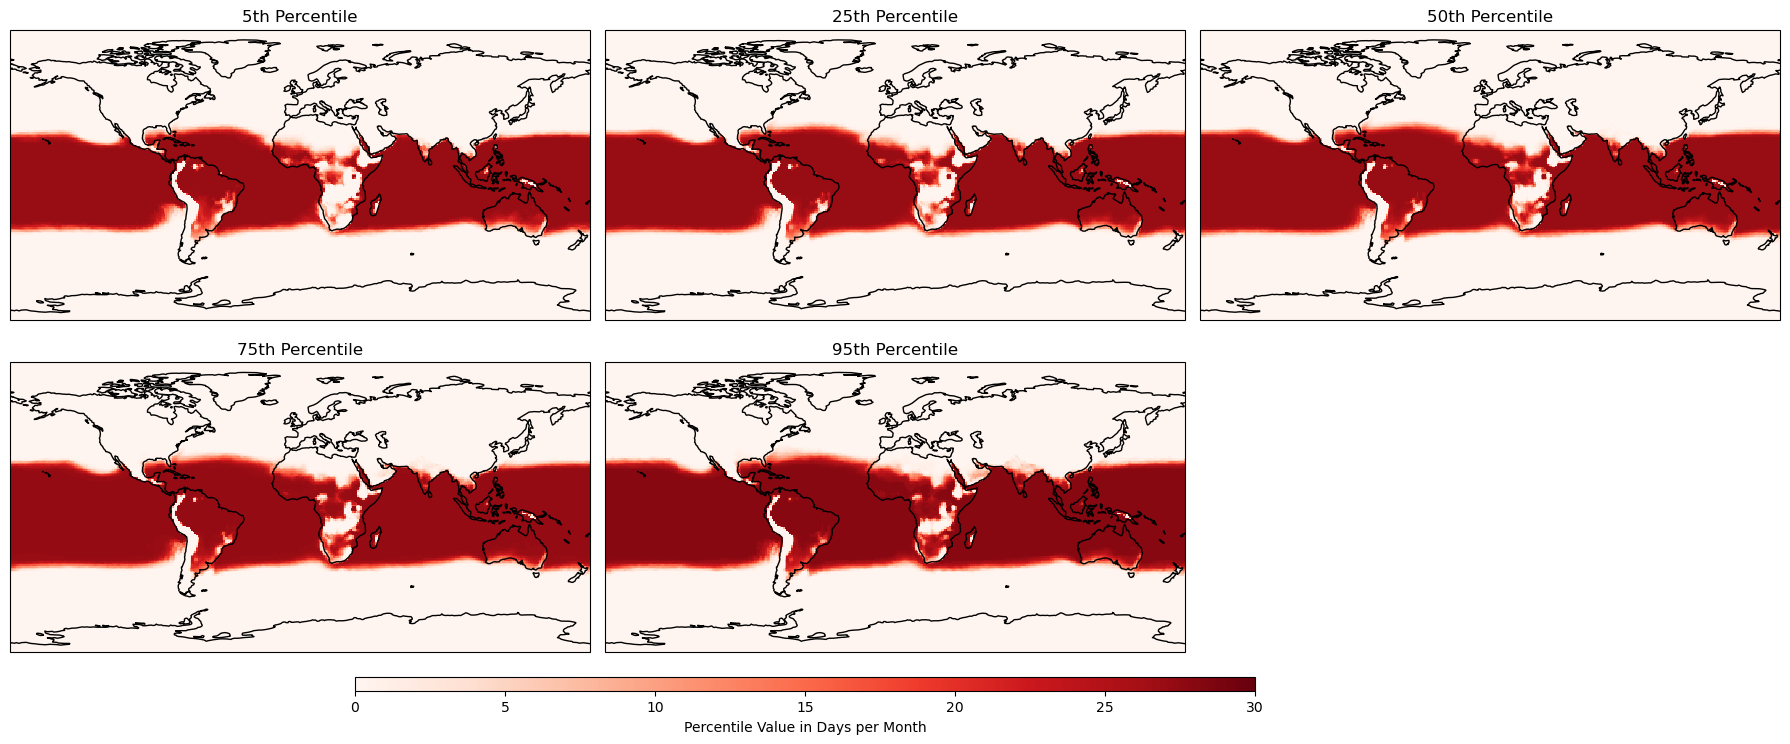

In [9]:
# Define the percentiles to plot
percentiles = ["ensemble_p5",  "ensemble_p25", "ensemble_p50", "ensemble_p75",  "ensemble_p95"]
percentile_labels = ["5th", "25th", "50th", "75th",  "95th"]

# Initialize variables to find global min and max across all percentiles
global_min = None
global_max = None

# Find the global minimum and maximum values
for percentile in percentiles:
    percentile_data = ds[percentile][0, :, :]  
    if global_min is None or percentile_data.min() < global_min:
        global_min = percentile_data.min()
    if global_max is None or percentile_data.max() > global_max:
        global_max = percentile_data.max()

# Set up the figure and axes for subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 7),
                        subplot_kw={"projection": ccrs.PlateCarree()})
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Remove the last axes (since we have 5 percentiles and 6 subplot slots)
fig.delaxes(axs[5])

# Loop through each percentile and plot
for ax, percentile, label in zip(axs, percentiles, percentile_labels):
    # Select the data for January for the current percentile
    data_for_january = ds[percentile][1, :, :]
    
    # Plot the data
    p = data_for_january.plot(ax=ax, transform=ccrs.PlateCarree(),
                              cmap="Reds", add_colorbar=False,  # We will add a common colorbar later
                              vmin=global_min, vmax=global_max)  # Use the global min and max
    ax.coastlines()
    ax.set_title(f"{label} Percentile")

# Add a common colorbar for all subplots
cbar_ax = fig.add_axes([0.2, 0, 0.5, 0.02]) # Add an axes for the colorbar at the bottom
fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label="Percentile Value in Days per Month")

# Adjust layout to prevent overlap
plt.tight_layout()

## Monthly hincast analysis of the Study area 
In the previous section, we inspect the data from a global perspective. Now we will narrow our focus to a specific region of interest (i.e. Germany and Switzerland) by cropping the data using a shapefile that outlines the borders of these two countries.

In [11]:
# import xarray as xr
# tn = '/Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/combined_tropical_nights_stats.nc'

/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202206/impact/netcdf_files/statistics_202206_event_4_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202206/impact/netcdf_files/statistics_202206_event_3_0.9.nc


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202206/impact/netcdf_files/statistics_202206_event_1_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202206/impact/netcdf_files/statistics_202206_event_2_0.9.nc


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202207/impact/netcdf_files/statistics_202207_event_4_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202207/impact/netcdf_files/statistics_202207_event_3_0.9.nc


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202207/impact/netcdf_files/statistics_202207_event_2_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202207/impact/netcdf_files/statistics_202207_event_1_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202208/impact/netcdf_files/statistics_202208_event_4_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202208/impact/netcdf_files/statistics_202208_event_1_0.9.nc


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202208/impact/netcdf_files/statistics_202208_event_3_0.9.nc
Statistics file saved: /Users/daraya/Documents/My_contribution/CDS_seasonal_forecast/data/tropical_nights/202208/impact/netcdf_files/statistics_202208_event_2_0.9.nc


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/Users/daraya/Documents/GitHub_files/CDS_seasonal_forecast/util_functions.py:3304: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gdf_buffered['geometry'] = shp_gdf_buffered.buffer(buffer_distance)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Clipped dataset saved to: /Users/daraya/Documents/test_data/data/combined_tropical_nights_hincast_stats_masked_with_ensemble.nc


/Users/daraya/Documents/GitHub_files/CDS_seasonal_forecast/util_functions.py:3350: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gdf.buffer(0.1).boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='Buffered Boundary')


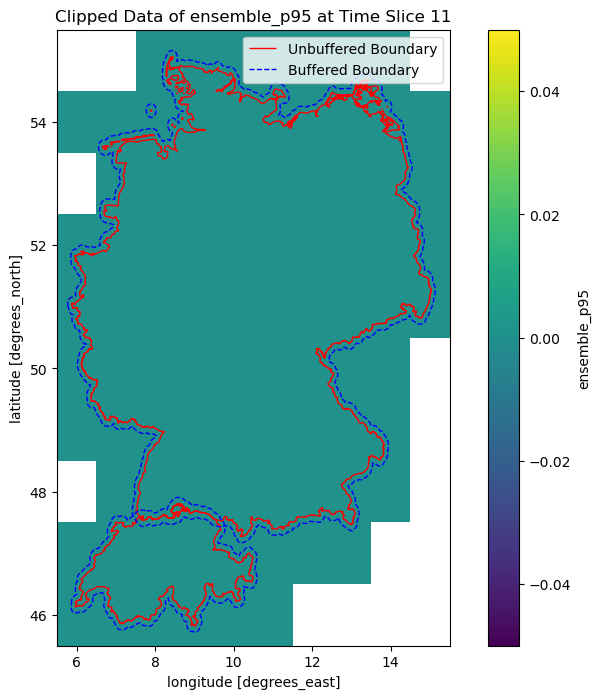

In [12]:
from util_functions import process_and_save_nc_data
from util_functions import plot_clipped_nc_data

shapefile_path = f"{INPUTDIR}/Countries_boundaries/DE_CH_boundaries_0.shp"
nc_file = f"{INPUTDIR}/combined_tropical_nights_stats.nc"
output_nc_file = f"{DATADIR}/combined_tropical_nights_hincast_stats_masked_with_ensemble.nc"
buffer_distance = 0.8
variable_to_plot = 'ensemble_p95'
time_slice = 11

# Process and save the data
process_and_save_nc_data(nc_file, shapefile_path, output_nc_file, buffer_distance)

# Plot the data
plot_clipped_nc_data(output_nc_file, shapefile_path, variable_to_plot, time_slice)

In [10]:
# open the subset dataset
tn = f'{DATADIR}/combined_tropical_nights_hincast_stats_masked_with_ensemble.nc'
ds = xr.open_dataset(tn)
ds

<xarray.Dataset> Size: 3MB
Dimensions:          (time: 365, latitude: 10, longitude: 10)
Coordinates:
  * time             (time) datetime64[ns] 3kB 1993-01-01 ... 2024-03-01
    surface          float64 8B ...
  * latitude         (latitude) float64 80B 55.0 54.0 53.0 ... 48.0 47.0 46.0
  * longitude        (longitude) float64 80B 6.0 7.0 8.0 9.0 ... 13.0 14.0 15.0
    quantile         float64 8B ...
Data variables:
    spatial_ref      int64 8B ...
    ensemble_mean    (time, latitude, longitude) float64 292kB ...
    ensemble_median  (time, latitude, longitude) float64 292kB ...
    ensemble_max     (time, latitude, longitude) int64 292kB ...
    ensemble_min     (time, latitude, longitude) int64 292kB ...
    ensemble_std     (time, latitude, longitude) float64 292kB ...
    ensemble_p5      (time, latitude, longitude) float64 292kB ...
    ensemble_p25     (time, latitude, longitude) float64 292kB ...
    ensemble_p50     (time, latitude, longitude) float64 292kB ...
    ensemble_p75     (time, latitude, longitude) float64 292kB ...
    ensemble_p95     (time, latitude, longitude) float64 292kB ...

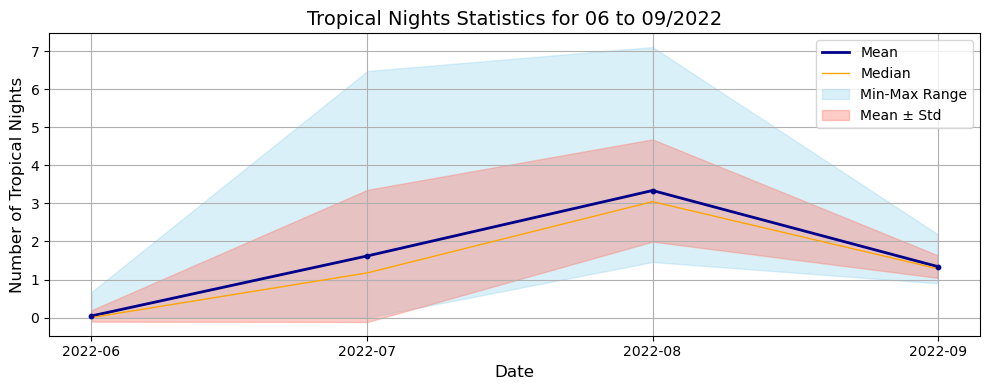

In [11]:
def plot_tropical_nights_statistics_for_months_combined(ds, year, month_list):
    # Initialize an empty DataFrame to store combined statistics
    combined_df = pd.DataFrame()

    for month in month_list:
        # Filter the dataset for the specified month and year
        start_date = f"{year}-{month}-01"
        end_date = pd.to_datetime(start_date) + pd.offsets.MonthEnd(1)  # Get the end of the month

        ds_filtered = ds.sel(time=slice(start_date, end_date))

        # Aggregate each statistic over latitude and longitude
        stats = {
            'Mean': ds_filtered['ensemble_mean'].mean(dim=['latitude', 'longitude']),
            'Median': ds_filtered['ensemble_median'].mean(dim=['latitude', 'longitude']),
            'Max': ds_filtered['ensemble_max'].mean(dim=['latitude', 'longitude']),
            'Min': ds_filtered['ensemble_min'].mean(dim=['latitude', 'longitude']),
            'Std': ds_filtered['ensemble_std'].mean(dim=['latitude', 'longitude'])
        }

        # Convert to pandas DataFrame for easier plotting
        month_df = pd.DataFrame({key: val.values for key, val in stats.items()}, index=pd.date_range(start=start_date, periods=len(stats['Mean']), freq='D'))

        # Append to the combined DataFrame
        combined_df = pd.concat([combined_df, month_df])

    # Plotting the combined DataFrame
    plt.figure(figsize=(10, 4))  # Make the figure smaller
    ax = plt.subplot(1, 1, 1)  # Create a single subplot

    # Plot each statistic
    ax.plot(combined_df.index, combined_df['Mean'], label='Mean', color='darkblue', linewidth=2)
    ax.plot(combined_df.index, combined_df['Median'], label='Median', color='orange', linewidth=1)
    ax.fill_between(combined_df.index, combined_df['Min'], combined_df['Max'], color='skyblue', alpha=0.3, label='Min-Max Range')
    ax.fill_between(combined_df.index, combined_df['Mean'] - combined_df['Std'], combined_df['Mean'] + combined_df['Std'], color='salmon', alpha=0.4, label='Mean ± Std')

    # Adding markers for the mean
    ax.scatter(combined_df.index, combined_df['Mean'], color='darkblue', s=10, zorder=5)

    # Set titles and labels
    ax.set_title(f'Tropical Nights Statistics for {month_list[0]} to {month_list[-1]}/{year}', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Tropical Nights', fontsize=12)
    ax.grid(True)
    ax.legend(frameon=True, fontsize=10)

    # Set x-axis formatter for months
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

# Example usage
ds = xr.open_dataset(f'{DATADIR}/combined_tropical_nights_hincast_stats_masked_with_ensemble.nc')
plot_tropical_nights_statistics_for_months_combined(ds, 2022, ['06', '07', '08', '09'])

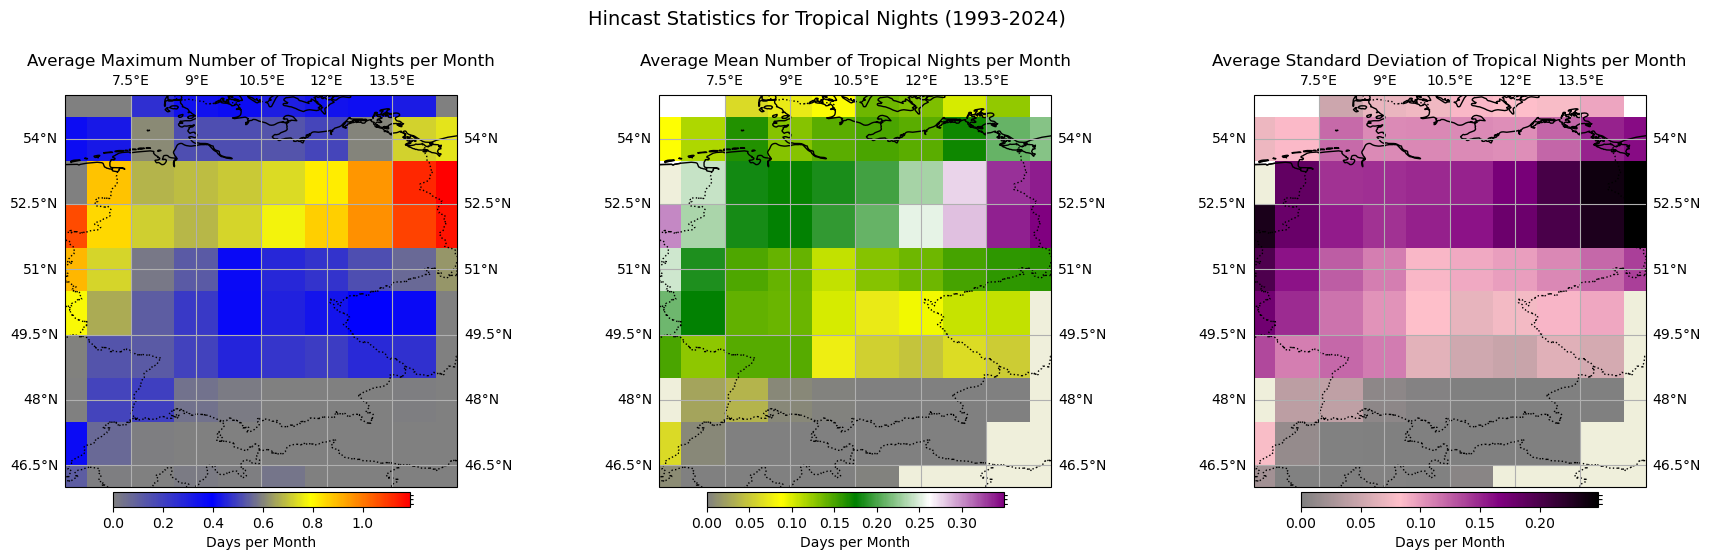

In [12]:
# Determine geographic extents directly from the data if possible
lon_min, lon_max = ds.longitude.min().item(), ds.longitude.max().item()
lat_min, lat_max = ds.latitude.min().item(), ds.latitude.max().item()

# Define color maps with grey for 0.0
cmap_max = colors.LinearSegmentedColormap.from_list('custom_cmap_max', ['grey', 'blue', 'yellow', 'red'])
cmap_mean = colors.LinearSegmentedColormap.from_list('custom_cmap_mean', ['grey', 'yellow', "green", 'white', 'purple'])
cmap_std = colors.LinearSegmentedColormap.from_list('custom_cmap_std', ['grey', 'pink', "purple", 'black'])

# Sum all the data across the time dimension for each category
tn_eu_hincast_max = ds["ensemble_max"].mean(dim="time")
tn_eu_hincast_mean = ds["ensemble_mean"].mean(dim="time")
tn_eu_hincast_std = ds["ensemble_std"].mean(dim="time")

# Plot properties
fig = plt.figure(figsize=(23, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0, height_ratios=[1, 5])

# Titles
fig.suptitle("Hincast Statistics for Tropical Nights (1993-2024)", fontsize=14, y=0.80)
titles = ["Average Maximum Number of Tropical Nights per Month", "Average Mean Number of Tropical Nights per Month", "Average Standard Deviation of Tropical Nights per Month"]

# Data to plot
data_to_plot = [tn_eu_hincast_max, tn_eu_hincast_mean, tn_eu_hincast_std]
cmaps = [cmap_max, cmap_mean, cmap_std]

for i, (data, title, cmap) in enumerate(zip(data_to_plot, titles, cmaps)):
    ax = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Use imshow for plotting, but keep the data's original coordinates
    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=True,
                    cbar_kwargs={'shrink': 0.5, 'pad': 0.01, 'orientation': 'horizontal', 'label': 'Days per Month'})
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.gridlines(draw_labels=True)

    ax.set_title(title)

plt.show()

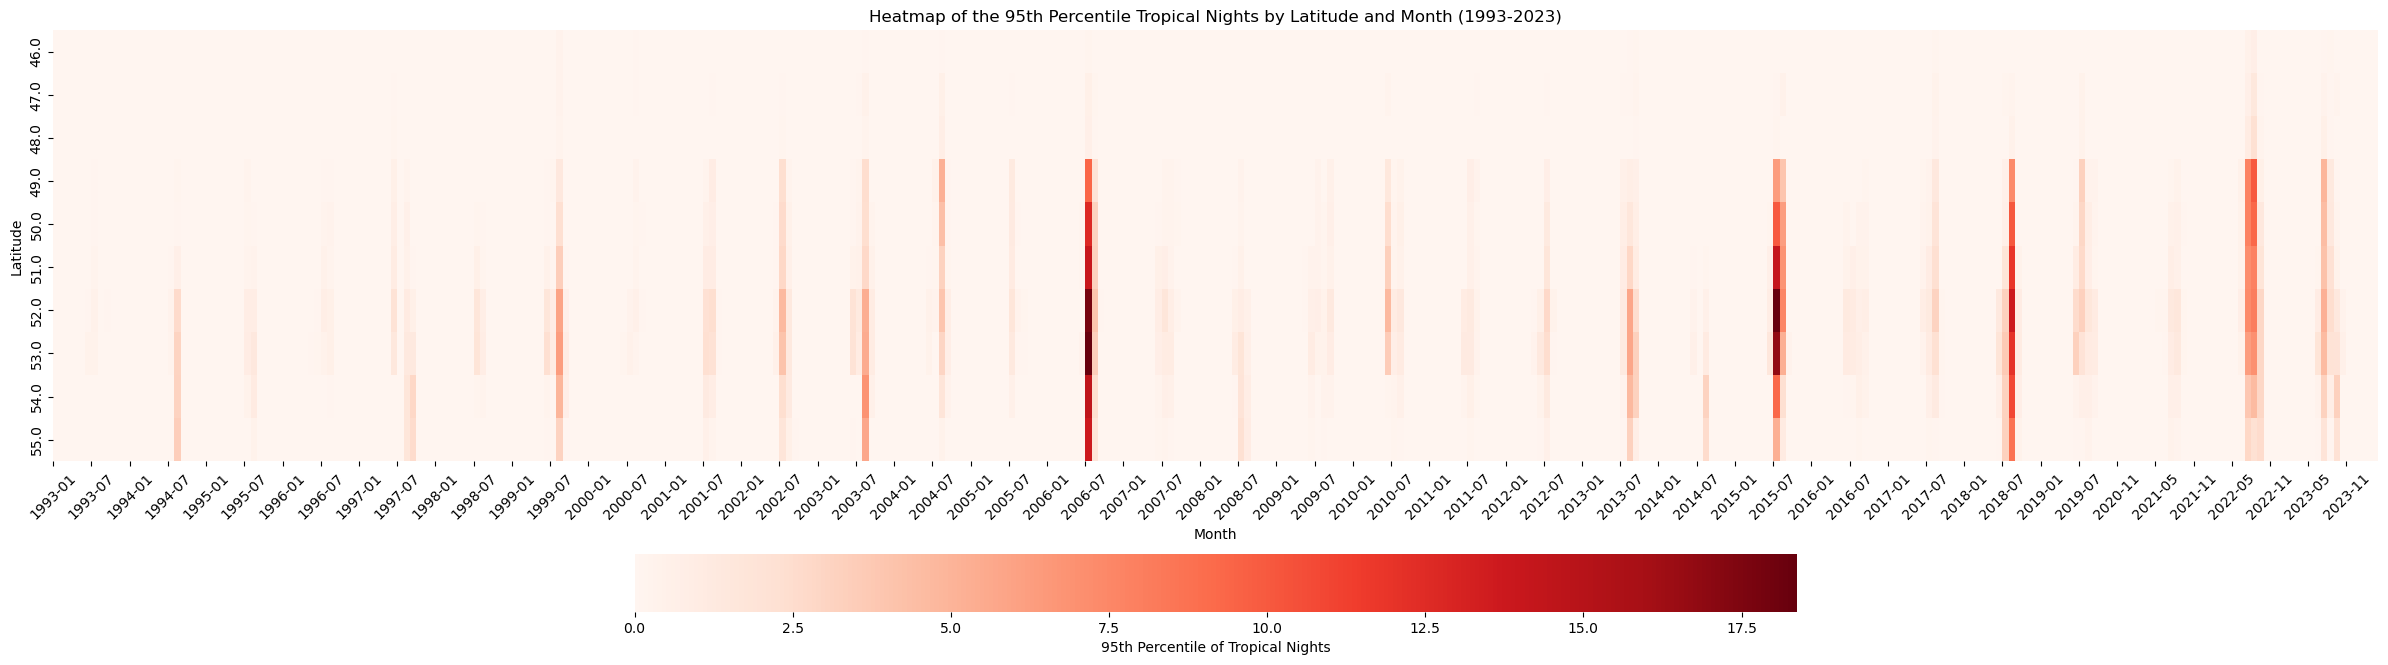

In [13]:
# Selecting the 95th percentile data
ensemble_p95 = ds['ensemble_p95']
ensemble_p95_avg = ensemble_p95.mean(dim='longitude')

# Convert xarray dataset to pandas dataframe for easier plotting with seaborn
df = ensemble_p95_avg.to_dataframe().reset_index()
df['month'] = df['time'].dt.strftime('%Y-%m')  # Create a month-year column for plotting

# Pivot the DataFrame to make it suitable for heatmap plotting
heatmap_data = df.pivot(index="latitude", columns="month", values="ensemble_p95")

# Plotting
plt.figure(figsize=(30, 8))
ax = sns.heatmap(heatmap_data, cmap='Reds', cbar_kws={'label': '95th Percentile of Tropical Nights', 'orientation': 'horizontal', 'shrink': 0.5})
ax.set_title('Heatmap of the 95th Percentile Tropical Nights by Latitude and Month (1993-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')

# Adjust x-ticks to display fewer labels and improve readability
x_dates = df['month'].drop_duplicates()  # get unique months
ax.set_xticks(range(0, len(x_dates), 6))  # set ticks every 6 months
ax.set_xticklabels(x_dates[::6].tolist(), rotation=45)  # set labels every 6 months, rotating them for better visibility

plt.show()

Statistical Summary for Ensemble Metrics:
                 count      mean       std  min  25%  50%  75%        max
metric                                                                   
ensemble_max   36500.0  0.394247  1.580682  0.0  0.0  0.0  0.0  26.000000
ensemble_mean  31390.0  0.123809  0.796506  0.0  0.0  0.0  0.0  18.866667


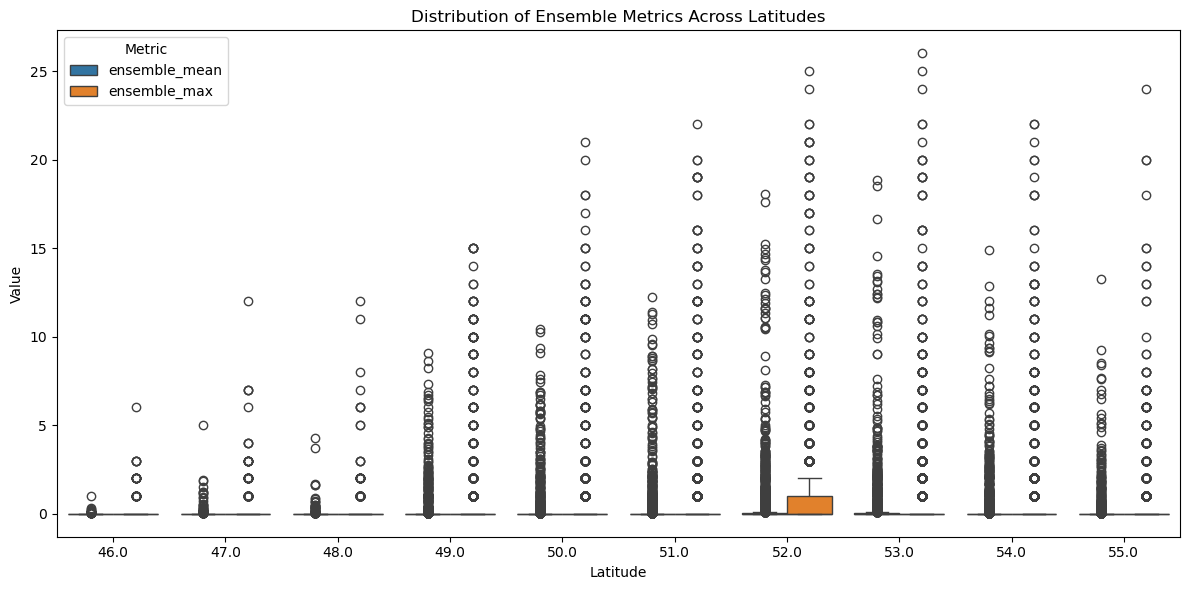

In [14]:
variables = ['ensemble_mean', 'ensemble_max']
data = []

for var in variables:
    # Convert the DataArray to a DataFrame, reset the index to make all dimensions columns
    temp_df = ds[var].to_dataframe().reset_index()
    # Add a column to identify the metric (mean, max, min)
    temp_df['metric'] = var
    # Rename the value column to a generic name for easier plotting
    temp_df.rename(columns={var: 'value'}, inplace=True)
    data.append(temp_df)

# Combine all the dataframes into one
combined_df = pd.concat(data, ignore_index=True)

# Display statistical summary for each metric
print("Statistical Summary for Ensemble Metrics:")
print(combined_df.groupby("metric")['value'].describe())

# Boxplot for distributions across latitudes for each metric
plt.figure(figsize=(12, 6))
sns.boxplot(x="latitude", y="value", hue="metric", data=combined_df)
plt.title("Distribution of Ensemble Metrics Across Latitudes")
plt.xlabel("Latitude")
plt.ylabel("Value")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

Statistical Summary for Ensemble Metrics:
                     count      mean       std  min  25%       50%       75%  \
metric        time                                                             
ensemble_max  6     3000.0  0.572000  1.116198  0.0  0.0  0.000000  1.000000   
              7     3000.0  1.917000  3.693146  0.0  0.0  1.000000  2.000000   
              8     3000.0  1.804667  2.935425  0.0  0.0  1.000000  2.000000   
ensemble_mean 6     2580.0  0.084519  0.328264  0.0  0.0  0.000000  0.033333   
              7     2580.0  0.628793  2.076301  0.0  0.0  0.033333  0.200000   
              8     2580.0  0.663574  1.536998  0.0  0.0  0.050000  0.366667   

                          max  
metric        time             
ensemble_max  6      8.000000  
              7     26.000000  
              8     18.000000  
ensemble_mean 6      3.833333  
              7     18.866667  
              8     12.133333  


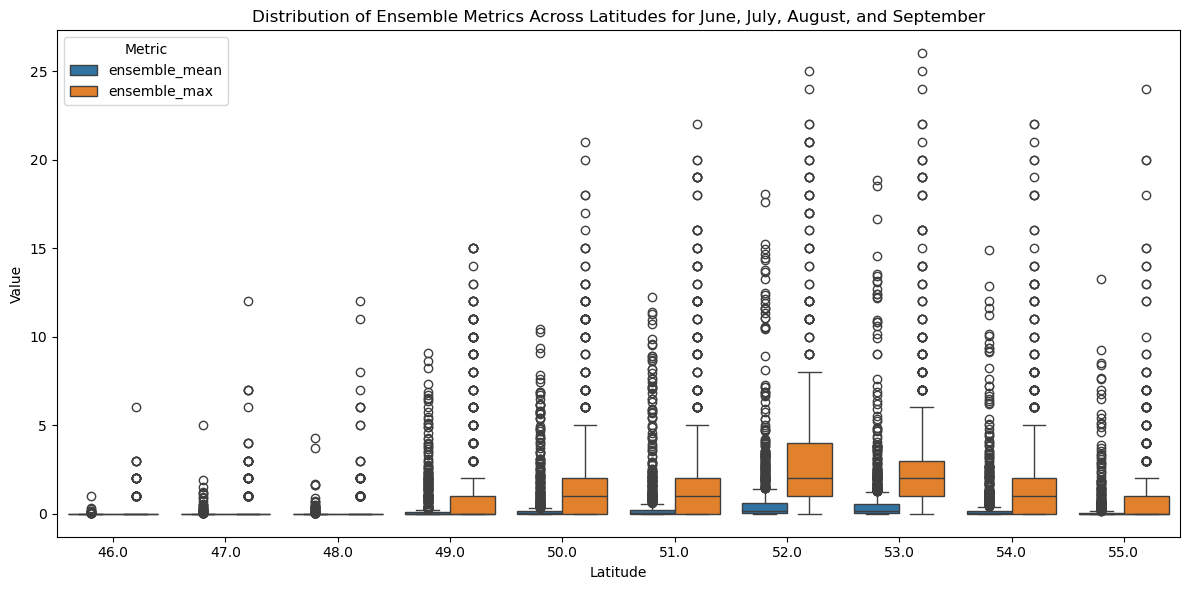

In [15]:
variables = ['ensemble_mean', 'ensemble_max']
data = []

# Filter the dataset for June, July, August, and September
ds_selected = ds.sel(time=ds['time'].dt.month.isin([6, 7, 8]))

for var in variables:
    # Convert the DataArray to a DataFrame, reset the index to make all dimensions columns
    temp_df = ds_selected[var].to_dataframe().reset_index()
    # Add a column to identify the metric (mean, max, min)
    temp_df['metric'] = var
    # Rename the value column to a generic name for easier plotting
    temp_df.rename(columns={var: 'value'}, inplace=True)
    data.append(temp_df)

# Combine all the dataframes into one
combined_df = pd.concat(data, ignore_index=True)

# Display statistical summary for each metric
print("Statistical Summary for Ensemble Metrics:")
print(combined_df.groupby(["metric", combined_df["time"].dt.month])['value'].describe())

# Boxplot for distributions across latitudes for each metric
plt.figure(figsize=(12, 6))
sns.boxplot(x="latitude", y="value", hue="metric", data=combined_df)
plt.title("Distribution of Ensemble Metrics Across Latitudes for June, July, August, and September")
plt.xlabel("Latitude")
plt.ylabel("Value")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [16]:
# Convert the 'monthly_mean' DataArray to a Pandas DataFrame for easier statistics
monthly_mean = ds["ensemble_mean"]
monthly_mean_df = monthly_mean.to_dataframe().reset_index()

# Display statistical summary of 'monthly_mean'
print(monthly_mean_df.describe())

                                time      latitude     longitude  surface  \
count                          36500  36500.000000  36500.000000  36500.0   
mean   2008-04-04 17:33:22.191780864     50.500000     10.500000      0.0   
min              1993-01-01 00:00:00     46.000000      6.000000      0.0   
25%              2000-08-01 00:00:00     48.000000      8.000000      0.0   
50%              2008-03-01 00:00:00     50.500000     10.500000      0.0   
75%              2015-10-01 00:00:00     53.000000     13.000000      0.0   
max              2024-03-01 00:00:00     55.000000     15.000000      0.0   
std                              NaN      2.872321      2.872321      0.0   

           quantile  ensemble_mean  
count  3.650000e+04   31390.000000  
mean   5.000000e-02       0.123809  
min    5.000000e-02       0.000000  
25%    5.000000e-02       0.000000  
50%    5.000000e-02       0.000000  
75%    5.000000e-02       0.000000  
max    5.000000e-02      18.866667  
std    3.0

The next plots calculate the average change per year for each month across the entire dataset. The result is a single value per month that represents the average yearly change in the 95th percentile intensity of tropical nights. This analysis provides a simplified but powerful view into the trends of tropical nights, allowing us to understand whether the frequency or intensity of these events is increasing, decreasing, or remaining stable across each month of the year, on average. By averaging the changes, you get a clear picture of the long-term trend, which is crucial for understanding climate patterns and potentially guiding policy or preparedness strategies in response to increasing temperatures at night.

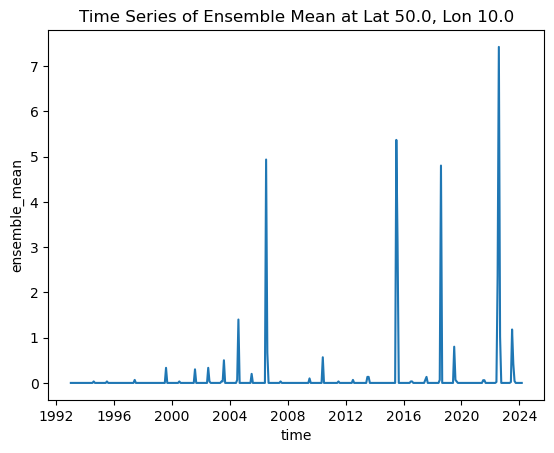

In [17]:
# Time Series Analysis
# Plotting time series for a specific location to observe trends
specific_lat = 50.0
specific_lon = 10.0
ds.sel(latitude=specific_lat, longitude=specific_lon)["ensemble_mean"].plot()
plt.title(f"Time Series of Ensemble Mean at Lat {specific_lat}, Lon {specific_lon}")
plt.show()

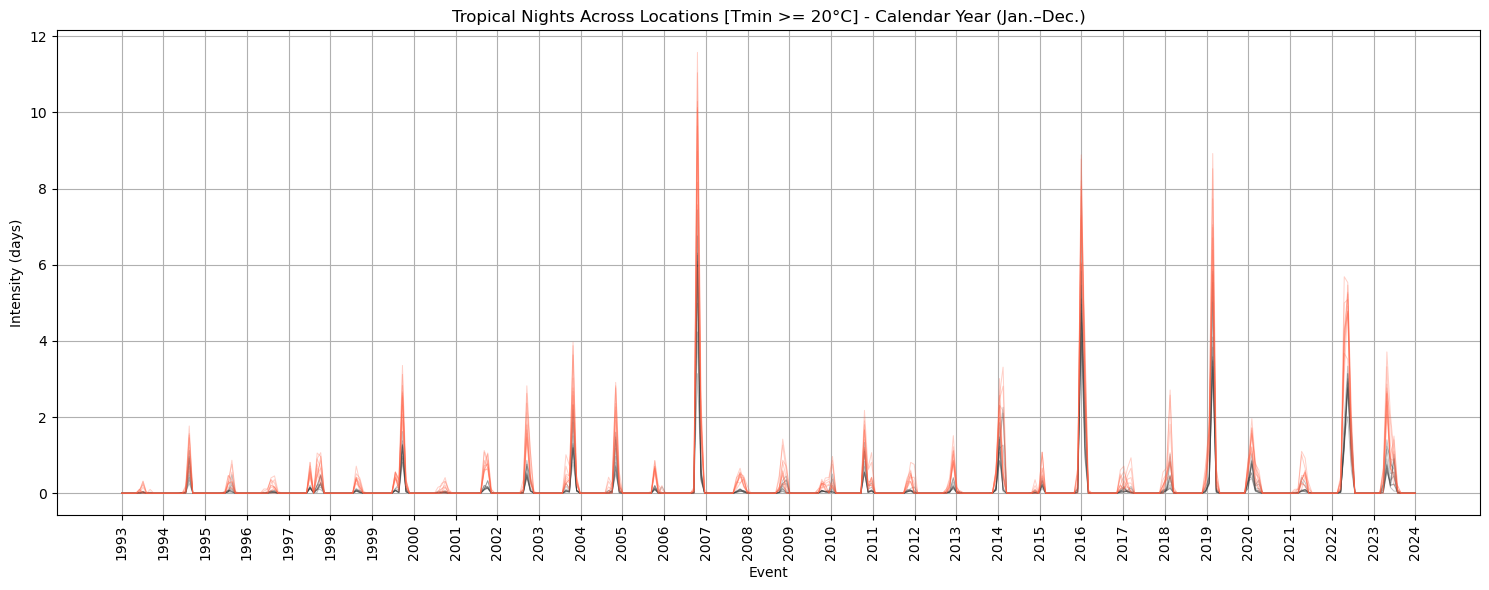

In [18]:
# Load intensity data for 'ensemble_mean' and 'ensemble_p95'
intensity_mean = ds['ensemble_mean'].values  # Load mean intensity data as a NumPy array
intensity_p95 = ds['ensemble_p95'].values   # Load 95th percentile intensity data as a NumPy array

# Replace missing values (NaN) with zero for both datasets
intensity_mean = np.nan_to_num(intensity_mean)
intensity_p95 = np.nan_to_num(intensity_p95)

# Calculate the average intensity across all locations for each event for both datasets
average_intensity_mean = np.mean(intensity_mean, axis=1)
average_intensity_p95 = np.mean(intensity_p95, axis=1)

# Number of events is the length of the average_intensity array
num_events = len(average_intensity_mean)

# Setup the figure and axis for plotting
plt.figure(figsize=(15, 6))

# Plotting the average intensity of tropical nights across locations for each event
plt.plot(range(1, num_events + 1), average_intensity_mean, color="#3b3b3b", alpha=0.3, linewidth=0.7, label="Avg. Intensity (Mean)")
plt.plot(range(1, num_events + 1), average_intensity_p95, color="#FF6347", alpha=0.3, linewidth=0.7, label="Avg. Intensity (95th Percentile)")

# Adding labels and title to the plot
plt.xlabel("Event")
plt.ylabel("Intensity (days)")
plt.title("Tropical Nights Across Locations [Tmin >= 20°C] - Calendar Year (Jan.–Dec.)")


# Defining the x-axis tick positions and labels 
years = np.arange(1993, 2025)  # Years from 1993 to 2024
tick_positions = np.linspace(1, num_events, len(years))
plt.xticks(tick_positions, years, rotation=90)  # Rotate labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

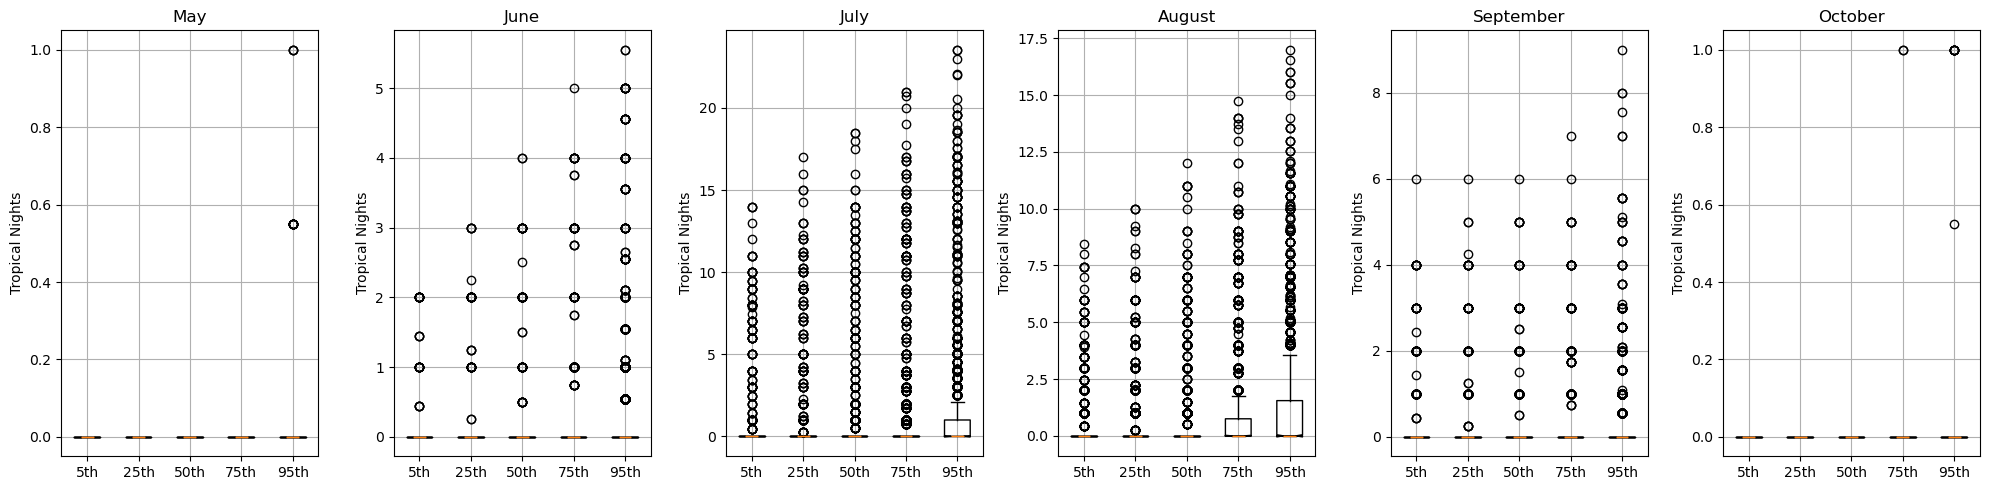

In [19]:
percentiles = ["ensemble_p5", "ensemble_p25", "ensemble_p50", "ensemble_p75", "ensemble_p95"]
percentile_labels = ["5th", "25th", "50th", "75th", "95th"]

# Collect data only for months with data
boxplot_data = {}
months_with_data = []  # To keep track of months with valid data

# Adjust the range to May (5) to October (10)
for month in range(5, 11):
    monthly_data = []
    has_data = True  # Flag to check if data exists for all percentiles

    for percentile in percentiles:
        data = ds[percentile].sel(time=ds['time'].dt.month == month).values.flatten()
        valid_data = data[~np.isnan(data)]

        if valid_data.size > 0:
            monthly_data.append(valid_data)
        else:
            has_data = False
            break

    if has_data and monthly_data:  # Only add to dict if there is valid data for the month
        boxplot_data[month] = monthly_data
        months_with_data.append(month)  # Record the month index

# Number of plots is the number of months with valid data
num_plots = len(months_with_data)
if num_plots > 0:
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 5), squeeze=False)  # Prevents axs from being squeezed into a non-iterable if single plot
    axs = axs.flatten()

    month_names = ['May', 'June', 'July', 'August', 'September', 'October']

    # Plot for months with data
    for i, month in enumerate(months_with_data):
        # Here we need to make sure the number of labels matches the number of datasets
        num_data_sets = len(boxplot_data[month])
        axs[i].boxplot(boxplot_data[month], tick_labels=percentile_labels[:num_data_sets], notch=True, vert=True)
        axs[i].set_title(month_names[month - 5])  # Adjusted index for month names
        axs[i].set_ylabel("Tropical Nights")
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot for any month.")

The choice of using the assembled mean, maximum, minimum of heat waves days depends on your specific analysis goals and how you want to explore a heat wave. Here are some considerations for each approach:

- __Assembled Mean__:
  - Pros: Using the mean of all members can provide a balanced representation of the ensemble's heat waves days.
  - Cons: It may not capture extreme heat waves days spikes if there are variations among ensemble members.
- __Assembled Maximum__:
  - Pros: Using the maximum temperature among all members can identify the hottest conditions.
  - Cons: It may result in false positives if a single outlier member has an extremely high value of heat waves days.
- __Assembled Minimum__:
  - Pros: Using the minimum temperature can identify consistently hot conditions across all members.
  - Cons: It may miss heat waves that are driven by variations in temperature among members.

## Start estimating the exposure via CLIMADA

### Install CLIMADA

CLIMADA is compatible with Windows, macOS, and Linux operating systems. It can be installed from source code and offers two installation options: user installation and expert/developer installation. Please refer to the [installation guide](https://climada-python.readthedocs.io/en/latest/guide/install.html) for detailed instructions. For these tutorials, we require the expert installation.

>Tip: Additionally, CLIMADA provides datasets through its [Data-API](https://climada.ethz.ch/data-types/), including centroid data, hazard data, and exposure data, which can be easily utilized for CLIMADA analyses

## Set up hazard

### Set a heat wave hazard 

In this exercise, our objective is to examine the tropical night hazard in Europe, aligning with the definition provided by MeteoSwiss. For our analysis, a tropical night is defined as a period where nighttime temperatures do not fall below 20 degrees Celsius. This definition is pivotal for assessing the potential impact of tropical nights on the region.

Our analysis is grounded in the seasonal forecast data from Copernicus, spanning from 1993 to the present, which includes both historical hindcasts up to 2016 and ongoing forecasts from 2017 onwards. This dataset is globally comprehensive, presented on a regular latitude-longitude grid with a horizontal resolution of 1° x 1°, and offers monthly temporal resolution. The format of the data is GRIB, and it is updated in real-time, with forecasts released once per month—specifically, on the 6th at 12UTC for ECMWF and on the 10th at 12 UTC for other originating centers. By focusing on this dataset, our objective is to delve into the patterns, intensity, and frequency of tropical nights across Europe, laying a solid foundation for evaluating the impact of these extreme weather events. 

The primary aim of this exercise is to elucidate the long-term trends of tropical nights in Germany and Switzerland, considering both hindcast and forecast data without lags. We review the temporal changes on the data year by year. Through this analysis, we seek to enhance our understanding of the potential impacts of tropical nights on the region, thereby aiding in the development of effective mitigation and adaptation strategies. A key aspect of our approach is the flexibility in defining tropical nights; while we initially set the threshold at 20 degrees Celsius, this definition can be modified according to specific needs or local climate conditions. Additionally, a range of statistics are calculated and provided, allowing users to select indicators that best meet their analytical needs. However, here we focus on the 95th percentile of tropical nights in the historical months since the 95th percentile highlights the most extreme conditions. Focusing on the 95th percentile is crucial for emergency preparedness and response planning, as it captures the worst-case scenarios that occur less frequently but can have potentially severe consequences. This approach helps stakeholders to prepare for and mitigate the most extreme impacts of tropical nights, ensuring that systems and communities are resilient against these harsh conditions.


>**Important:** CLIMADA currently operates using the EPSG:4326 projection, also known as WGS 84. To ensure compatibility, your data must be transformed to this coordinate system. Support for additional coordinate systems will be added in the near future.

>**Note**: CLIMADA uses sparse matrices for computational and memory efficiency. Sparse matrices store only non-zero elements, saving memory and speeding up calculations, especially for large datasets. This approach enhances scalability and flexibility, allowing the model to handle larger and more complex problems efficiently. It also facilitates integration with other scientific computing tools.


>**Note:** Please be aware that in CLIMADA, any missing, Not Applicable or "NA" values in the hazard matrix will be substituted with zeros.

>**Tip:** If you only want to know how much of the population has been or will be affected by tropical nights, you can convert the continuous tropical night values to binary data. This way, you will know whether or not the population is affected by tropical nights, without having to consider the magnitude of the tropical nights.

>**Tip:** If you only want to see the content of a hazard you can use **print(dir(hazard))**

## Create a hazard object

### Create a hazard assessment based on the p95 statistics 

In [20]:
from climada.hazard import Hazard

tn = f'{DATADIR}/combined_tropical_nights_hincast_stats_masked_with_ensemble.nc'
# Load the dataset to extract the correct dates
ds = xr.open_dataset(tn)

# Convert the 'time' coordinate to a list of formatted strings
event_dates = pd.to_datetime(ds['time'].values).strftime('%Y-%m-%d')

# Load the hazard data, ensuring the coordinate names match those in the dataset
hazard_p95 = Hazard.from_xarray_raster_file(tn, 
                                        hazard_type='Tropical_Nights', 
                                        intensity_unit="days", 
                                        intensity='ensemble_p95', # We are using maximum, just for 
                                        coordinate_vars=dict(event="time", longitude="longitude", latitude="latitude"))
#hazard_mean.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard_mean.event_name))
#mean_heatwave_days_per_event = np.mean(hazard_mean.intensity.toarray(), axis=1)
#relative_frequencies = mean_heatwave_days_per_event / np.sum(mean_heatwave_days_per_event)
#hazard_mean.frequency = relative_frequencies
hazard_p95.check
# Access hazard attributes
print('Hazard attributes:')
print(' - Shape of intensity:', hazard_p95.intensity.shape)
print(' - Centroids:', hazard_p95.centroids.shape)
print(' - Units:', hazard_p95.units)
print(' - event_id:', hazard_p95.event_id)
print(' - frequency:', hazard_p95.frequency)
print(' - min, max fraction:', hazard_p95.fraction.min(), hazard_p95.fraction.max())
print(' - Date:', hazard_p95.date)
print('min, max fraction: ', hazard_p95.fraction.min(), hazard_p95.fraction.max())
print(' - event_name:')
hazard_p95.event_name

Hazard attributes:
 - Shape of intensity: (365, 100)
 - Centroids: (10, 10)
 - Units: days
 - event_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221

['1993-01-01',
 '1993-02-01',
 '1993-03-01',
 '1993-04-01',
 '1993-05-01',
 '1993-06-01',
 '1993-07-01',
 '1993-08-01',
 '1993-09-01',
 '1993-10-01',
 '1993-11-01',
 '1993-12-01',
 '1994-01-01',
 '1994-02-01',
 '1994-03-01',
 '1994-04-01',
 '1994-05-01',
 '1994-06-01',
 '1994-07-01',
 '1994-08-01',
 '1994-09-01',
 '1994-10-01',
 '1994-11-01',
 '1994-12-01',
 '1995-01-01',
 '1995-02-01',
 '1995-03-01',
 '1995-04-01',
 '1995-05-01',
 '1995-06-01',
 '1995-07-01',
 '1995-08-01',
 '1995-09-01',
 '1995-10-01',
 '1995-11-01',
 '1995-12-01',
 '1996-01-01',
 '1996-02-01',
 '1996-03-01',
 '1996-04-01',
 '1996-05-01',
 '1996-06-01',
 '1996-07-01',
 '1996-08-01',
 '1996-09-01',
 '1996-10-01',
 '1996-11-01',
 '1996-12-01',
 '1997-01-01',
 '1997-02-01',
 '1997-03-01',
 '1997-04-01',
 '1997-05-01',
 '1997-06-01',
 '1997-07-01',
 '1997-08-01',
 '1997-09-01',
 '1997-10-01',
 '1997-11-01',
 '1997-12-01',
 '1998-01-01',
 '1998-02-01',
 '1998-03-01',
 '1998-04-01',
 '1998-05-01',
 '1998-06-01',
 '1998-07-

### Create a hazard assessment based on the mean statistics 

In [21]:
# Load the hazard data, ensuring the coordinate names match those in the dataset
hazard_mean = Hazard.from_xarray_raster_file(tn, 
                                        hazard_type='Tropical_Nights', 
                                        intensity_unit="days", 
                                        intensity='ensemble_mean', # We are using maximum, just for 
                                        coordinate_vars=dict(event="time", longitude="longitude", latitude="latitude"))
#hazard_mean.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard_mean.event_name))
#mean_heatwave_days_per_event = np.mean(hazard_mean.intensity.toarray(), axis=1)
#relative_frequencies = mean_heatwave_days_per_event / np.sum(mean_heatwave_days_per_event)
#hazard_mean.frequency = relative_frequencies
#hazard_mean.check

### Create a hazard assessment based on the maximum statistics 

In [22]:
# Load the hazard data, ensuring the coordinate names match those in the dataset
hazard_max = Hazard.from_xarray_raster_file(tn, 
                                        hazard_type='Tropical_Nights', 
                                        intensity_unit="days", 
                                        intensity='ensemble_max', # We are using maximum, just for 
                                        coordinate_vars=dict(event="time", longitude="longitude", latitude="latitude"))
#hazard_max.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard_max.event_name))
#max_heatwave_days_per_event = np.mean(hazard_max.intensity.toarray(), axis=1)
#relative_frequencies_max = max_heatwave_days_per_event / np.sum(max_heatwave_days_per_event)
#hazard_max.frequency = relative_frequencies_max

We can also visualize the hazard; in this case, we will visualize the hazard for event 346 (2022-09-01).

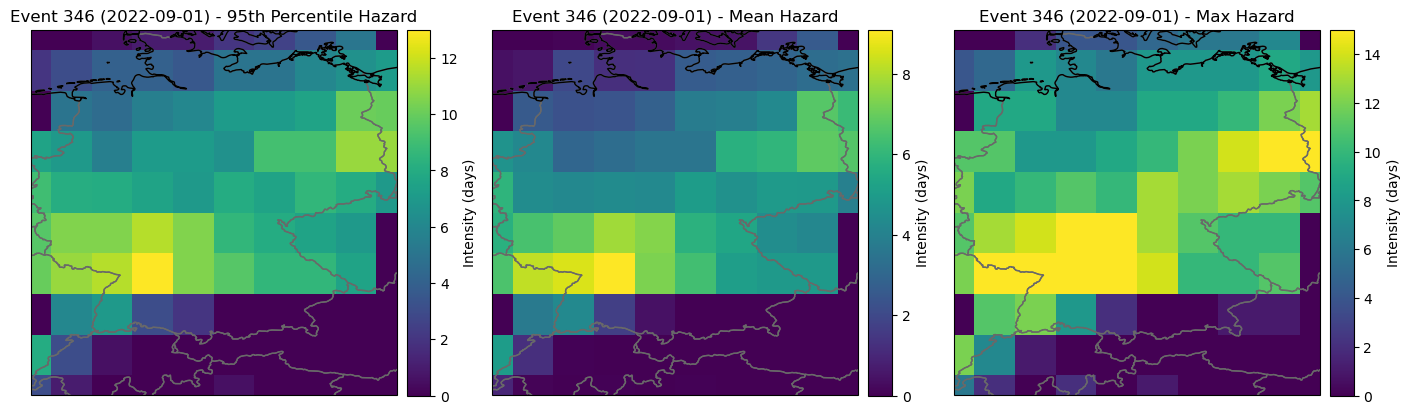

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.ravel()  # Flatten the array to make it easier to index

# Plot the 95th percentile intensity of the specified event on the first subplot
hazard_p95.plot_intensity(event=346, smooth=False, axis=axs[0], adapt_fontsize=True)
axs[0].set_title(f'Event 346 ({hazard_p95.event_name[346]}) - 95th Percentile Hazard')
axs[0].coastlines()  # Add coastlines to the plot

# Plot the mean intensity of the same event on the second subplot
hazard_mean.plot_intensity(event=346, smooth=False, axis=axs[1], adapt_fontsize=True)
axs[1].set_title(f'Event 346 ({hazard_p95.event_name[346]}) - Mean Hazard')
axs[1].coastlines()  # Add coastlines to the plot

# Plot the maximum intensity of the same event on the third subplot
hazard_max.plot_intensity(event=346, smooth=False, axis=axs[2], adapt_fontsize=True)
axs[2].set_title(f'Event 346 ({hazard_p95.event_name[346]}) - Max Hazard')
axs[2].coastlines()  # Add coastlines to the plot

plt.show()

We can also explore the intensity; for example, we observe that 26 heatwave days per month is the maximum recorded in the study period.

Max intensity stats:
Max intensity: 26
Min intensity: 0
Mean intensity: 0.39424657534246577
Standard Deviation: 1.580660446158477

95th Percentile intensity stats:
Max intensity: 23.549999999999997
Min intensity: 0.0
Mean intensity: 0.24008767123287658
Standard Deviation: 1.2306444321334864


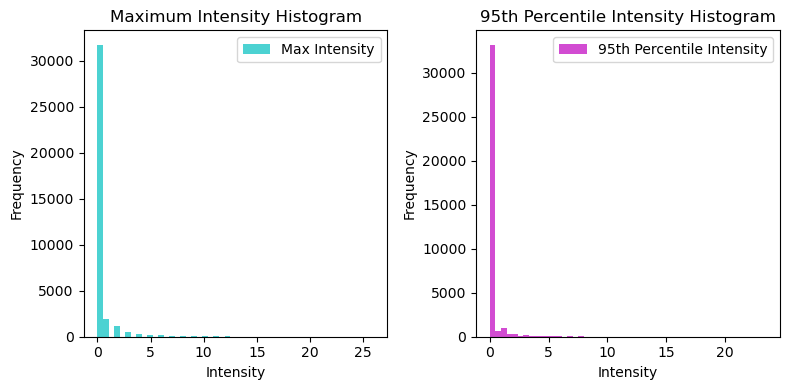

In [24]:
# Convert the sparse matrices to dense arrays for maximum and 95th percentile intensities
intensity_array_max = hazard_max.intensity.toarray()
intensity_array_p95 = hazard_p95.intensity.toarray()

# Statistics for maximum intensity
print("Max intensity stats:")
print("Max intensity:", np.max(intensity_array_max))
print("Min intensity:", np.min(intensity_array_max))
print("Mean intensity:", np.mean(intensity_array_max))
print("Standard Deviation:", np.std(intensity_array_max))

# Statistics for 95th percentile intensity
print("\n95th Percentile intensity stats:")
print("Max intensity:", np.max(intensity_array_p95))
print("Min intensity:", np.min(intensity_array_p95))
print("Mean intensity:", np.mean(intensity_array_p95))
print("Standard Deviation:", np.std(intensity_array_p95))

# Histogram for maximum intensity
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)  # first subplot
plt.hist(intensity_array_max.flatten(), bins=50, color='c', alpha=0.7, label='Max Intensity')
plt.title('Maximum Intensity Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()

# Histogram for 95th percentile intensity
plt.subplot(1, 2, 2)  # second subplot
plt.hist(intensity_array_p95.flatten(), bins=50, color='m', alpha=0.7, label='95th Percentile Intensity')
plt.title('95th Percentile Intensity Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

The graph below illustrates the intensification of heat waves across various locations over time.

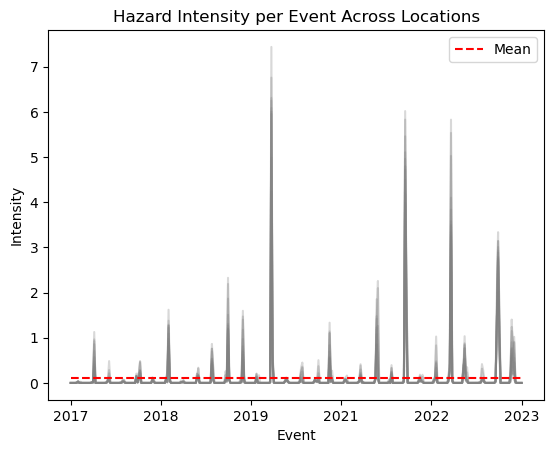

In [25]:
# Represents the intensity of heat wave events, retrieved from the dataset as an array
intensity = ds['ensemble_mean'].values # Represents the intensity of heat wave events, retrieved from the dataset as an array
intensity[np.isnan(intensity)] = 0 # Handle missing values (NaN) in the intensity array

# Calculate the average intensity across all locations for each event
average_intensity = intensity.mean(axis=1)

# Get the number of events
num_events = average_intensity.shape[0]

# Calculate the mean of the average intensities
mean_intensity = np.mean(average_intensity)

# Create the plot
plt.plot(range(1, num_events + 1), average_intensity, color='grey', alpha=0.3)

# Plot the mean line
plt.plot(range(1, num_events + 1), [mean_intensity] * num_events, color='red', linestyle='--', label='Mean')

# Customize the plot
plt.xlabel("Event")
plt.ylabel("Intensity")
plt.title("Hazard Intensity per Event Across Locations")
plt.legend()

# Set the x-axis tick labels
years = np.array([2017, 2018, 2019, 2021, 2022, 2023])
tick_positions = np.linspace(1, num_events, len(years))
plt.xticks(tick_positions, years)

# Show the plot
plt.show()

## Estimate exposure

After creating the hazard, we will proceed to create the exposure. Exposure refers to the collection of assets, individuals, infrastructure, and other elements within a specific area of interest that may be vulnerable to hazards. It encompasses their geographical coordinates, values, and other relevant information. There are two main options for obtaining exposure data:

- CLIMADA's Ready-to-Use Data: CLIMADA offers pre-existing exposure data called LitPop. LitPop combines estimates of asset value, economic activity, or population based on nightlight intensity and population count data. [Click for more information](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_LitPop.html) 

- Custom Data: If you have your own exposure data, you can provide the necessary information, such as asset values, economic activity, or population, to describe the exposed elements. [Click for more information](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures.html#Exposures-from-an-excel-file) 

Let's begin by exploring the utilization of LitPop exposure data (here we will downlaod data for europe and then we will refine our selection to switzerland and germany) and subsequently creating our own exposure data based on the Worldpop population count grid.

### Import class LitPop

#### Explore LitPop data

In [26]:
from climada.util.api_client import Client
client = Client()

In [27]:
# Fetch the list of LitPop dataset infos for Germany and Switzerland
litpop_datasets = client.list_dataset_infos(data_type='litpop', properties={'country_name':  ['Germany', 'Switzerland']})
litpop_df = client.into_datasets_df(litpop_datasets)

#### Visualize Exposures LitPop 

We will now turn our attention to the LitPop data to be used in this demonstration. But first, there are a few points to mention:
- You can provide either single countries or a list of countries.
- Load a default LitPop exposure entity for Switzerland and Germany in the year 2018 (ISO3-Codes 'CHE' and 'DEU').
- To incorporate all EU countries, you should add each of them like: ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE'].
- The default mode provides information on USD assets, while *fin_mode='pop'* provides information on population counts.
- To determine the weight between GDP and population in the LitPop operation, you can use, for instance, exponents=(1,0). This results in the following formula for creating the LitPop asset distribution: LitPop = Population^1 * GDP^0.

>**Tip:** The LitPop population data is based on gridded night lights from NASA at a 0.5 km resolution and gridded population data from CIESIN at a 1 km resolution. Therefore, LitPop can be retrieved at a maximum resolution of 0.5 km. Set with *"res_arcsec"*. [More information](https://essd.copernicus.org/articles/12/817/2020/)

In [28]:
country_codes = ['DEU', 'CHE']  # Add additional country codes to this list
exposures_list = []

for code in country_codes:
    exposure = client.get_exposures("litpop", properties={'country_iso3alpha': code, "exponents": "(0,1)"})
    exposures_list.append(exposure)

2025-01-04 16:34:09,505 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,546 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,580 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,605 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,622 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,663 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2025-01-04 16:34:09,697 - climada.entity.exposures.litpop.gpw_populati

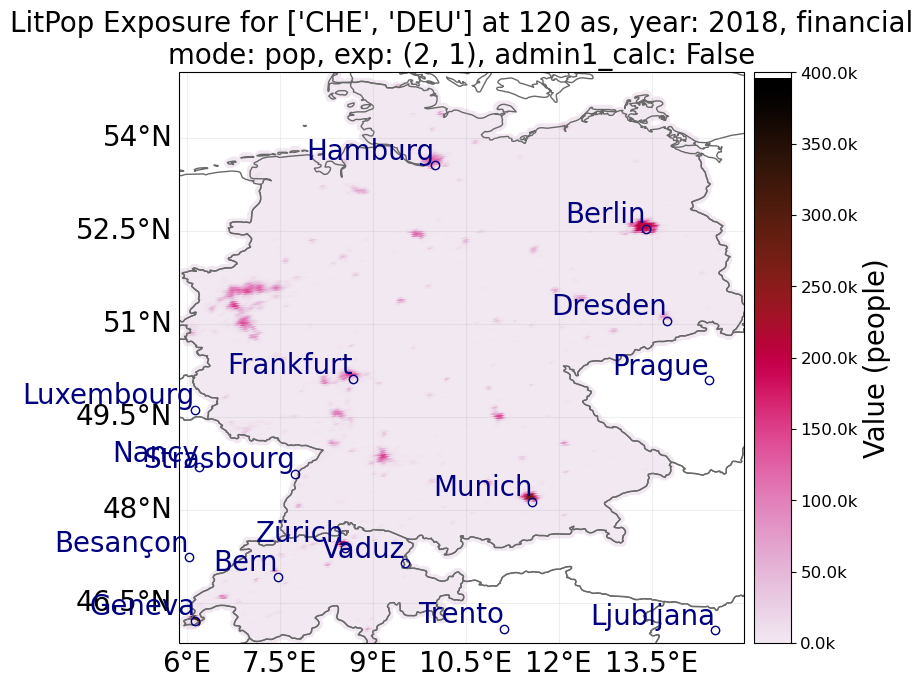

In [29]:
# Import class LitPop:
from climada.entity import LitPop
import rasterio

try:
    exposure = LitPop.from_countries(['CHE', 'DEU'], res_arcsec=120, fin_mode='pop', exponents=(2,1)) 
except FileExistsError as err:
    print("Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above.")
    raise err

# Plot using exposure.plot_scatter()
plot = exposure.plot_scatter()

# Get the current axis
ax = plt.gca()

# Modify the size of axis labels
fontsize_val = 12
plt.xticks(fontsize=fontsize_val)
plt.yticks(fontsize=fontsize_val)

# Set y-ticks and their labels to represent values in thousands
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([f'{ytick/1000:.1f}k' for ytick in yticks], clip_on=True)

# Ensure everything fits within the figure boundaries
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
# Visualize table of exposures LitPop
exposure.gdf.head()

value   latitude  longitude                  geometry  region_id  impf_
0  0.041824  47.783333   8.550000  POINT (8.55000 47.78333)        756      1
1  0.102677  47.783333   8.583333  POINT (8.58333 47.78333)        756      1
2  0.462942  47.783333   8.650000  POINT (8.65000 47.78333)        756      1
3  0.046644  47.750000   8.450000  POINT (8.45000 47.75000)        756      1
4  0.171815  47.750000   8.483333  POINT (8.48333 47.75000)        756      1

In [31]:
# Print exposure shape
print(exposure.gdf.shape) # 45763 rows and 6 columns

(45763, 6)


In [32]:
# Calculate the total population for each country
switzerland_population = round(exposure.gdf.loc[exposure.gdf['region_id'] == 756, 'value'].sum())
germany_population = round(exposure.gdf.loc[exposure.gdf['region_id'] == 276, 'value'].sum())
total_population = switzerland_population+germany_population

# Print the population count for Switzerland and Germany
print("Population in Switzerland:","{:,}".format(switzerland_population))
print("Population in Germany:","{:,}".format(germany_population))
print("Total Population:", "{:,}".format(total_population))

Population in Switzerland: 8,721,857
Population in Germany: 78,437,165
Total Population: 87,159,022


## Set up vulnerability and calculate damages

We will now explore the impact of heat waves on population. To do this, we will utilize hazard data spanning 100 years (from 1986 to 2085) as well as population data from LitPop. For this exercise, we will keep the exposure static, using only the population data from the year 2020. In subsequent exercises, we will incorporate future population scenarios.

Through impact estimation, we will generate a variety of statistics and graphs. You will learn how to calculate, create, and save these for further research.

The first step involves constructing an impact matrix that includes all the relevant parameters needed for a comprehensive impact assessment. This matrix will serve as a central repository for data, facilitating in-depth analysis and evaluation. Once the matrix is created, we will ensure its accessibility by saving it in all formats currently supported by CLIMADA.

In parallel, we will produce a series of maps that depict the impact of heat waves at various time points within the 100-year period under study. These maps will offer insights into both the spatial distribution of impact and temporal trends. To maintain the integrity and compatibility of this mapping data, we will save it in all geospatial formats supported by CLIMADA, allowing you to browse and select the format that best suits your needs.

### Creating an impact funtion

Here, we create a "dummy" impact function to examine the interaction of heat waves in LitPop. The impact function is created by utilizing the previously generated hazard and exposure datasets.

The impact function is crafted, incorporating the following key elements, [click for more information](https://climada-python.readthedocs.io/en/latest/tutorial/climada_engine_Impact.html):

* Intensity: This array represents the intensity levels of the hazard. It is created using the np.linspace function, which generates a sequence of evenly spaced values between the specified start (0) and end (10) points. In this case, the array contains 100 intensity levels ranging from 0 to 10.

* MDD: This array represents the Mean Degree of Damage (MDD) values associated with the hazard intensity levels. Similar to intensity, it is created using np.linspace to generate 100 evenly spaced values between 0 and 10.

* PAA: This array represents the Proportion of Assets Affected (PAA) values associated with the hazard intensity levels. In this case, paa is initialized with ones, resulting in an array of the same size as intensity with all elements set to 1. This suggests that there is a 100% probability of avoiding or mitigating the impact at each intensity level.

* impf_dum: An ImpactFunc object is instantiated with the provided parameters, including the hazard type, hazard ID, intensity, MDD, PAA, and units for intensity and MDD. The impact function is labeled as "dummy".

* impact_func_set: An ImpactFuncSet object is created, representing a collection or set of impact functions. The impf_dum impact function is added to this set using the ImpactFuncSet constructor with [impf_dum] as the argument.

* impf_ras.check(): This line of code calls the check() method on the impf_ras impact function set. 


>**Important:** This function allows for the analysis of the relationship between population and tropical nights. Here:
- if_tn.mdd = np.linspace(0, 30, 31)
  - Linear Scaling: If you want MDD to increase linearly from 0 to 1 as the number of tropical nights increases from 0 to 30, you can use np.linspace(0, 1, 31). This creates a linearly spaced array from 0 to 1 over 31 points, perfectly mapping the increase in nights to an increase in MDD.
  - Non-linear Scaling: For a non-linear progression that might more accurately reflect increasing sensitivity as the number of tropical nights increases, consider a quadratic or exponential function.
    - a) Quadratic progression for more sensitivity as nights increase
if_tn.mdd = (np.arange(31)/30)**2  # Squaring the fraction to have a sharper increase
    - b) Exponential progression
if_tn.mdd = 1 - np.exp(-np.arange(31)/5) 
<br>
- if_tn.intensity = np.arange(0, 31)
  - Start: The first number in the range, which in this case is 0.
  - Stop: The endpoint of the range which is not included in the array. For np.arange(0, 31), it stops before reaching 31.
  - Step: The increment between each value in the range. If not specified, the default value is 1.
<br>
- if_tn.paa = np.ones(31)
  - Set the PAA to 100% for all intensity levels
  
**This function serves as a demonstration only; you should define your own functions according to your specific field of study.**

<Axes: title={'center': 'Tropical_Nights 1: Tropical Nights Impact Function - 95th Percentile'}, xlabel='Intensity (days)', ylabel='Impact (%)'>

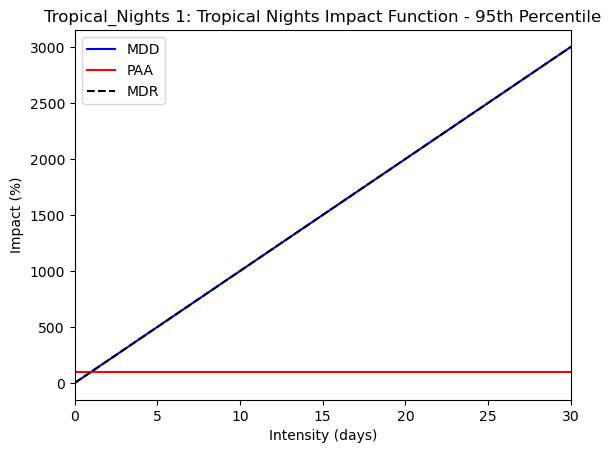

In [33]:
# Remember the libraries needed for this process
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
from climada.entity import LitPop
from climada.util.constants import ONE_LAT_KM

# Method is used to assign the centroids of hazard events to the exposure data. This step allows for the association of hazard events with specific population locations.
exposure.assign_centroids(hazard_p95)

intensity = hazard_p95.intensity

# Define the impact function set
if_set = ImpactFuncSet()
if_tn_p95 = ImpactFunc()
if_tn_p95.haz_type = 'Tropical_Nights'
if_tn_p95.id = 1
if_tn_p95.name = 'Tropical Nights Impact Function - 95th Percentile'
if_tn_p95.intensity_unit = 'days'
if_tn_p95.intensity = np.arange(0, 31)  # Using a realistic scale for the number of tropical nights in a month
if_tn_p95.mdd = np.linspace(0, 30, 31)  # Linearly increasing mean damage degree from 0 to 30
if_tn_p95.paa = np.ones(31)  # Assuming 100% of assets are affected at any intensity level
if_set.append(if_tn_p95)

# Plot the impact function
if_tn_p95.plot()

### Calculate impact

In the context of hazard impact assessment, we have computed several attributes that provide valuable information about the impacts of hazards on different locations. After calling `ImpactCalc(Exposure, ImpactFuncSet, Hazard).impact(save_mat=False)` the following atributes area calculated. Let's understand each attribute:

- at_event: This attribute is a numpy array that represents the impact for each hazard event, where the impact is calculated by summing the impacts over all locations. It provides a comprehensive view of the impact caused by each individual event.

- eai_exp: The expected annual impact for each location is represented by this numpy array. It takes into account the impacts from all hazard events, weighted by their respective frequencies. By summing the impacts over all events and locations, we obtain the total expected annual impact.

- aai_agg: This attribute is a single float value that represents the total annual average aggregated impact. It is calculated by summing the impacts over all events and locations, providing a measure of the overall impact of hazards on the exposed areas.

- impt_mat: The impact matrix is a sparse CSR matrix. It has the hazard events as rows and the exposure points (locations) as columns. The matrix has dimensions of num_events x num_exp. If the save_mat parameter was set to True during the impact calculation, the matrix contains the impact values for each event and exposure point. Otherwise, it remains empty.

- tot_value: The total exposure value affected is a single float value that represents the sum of values for all exposure locations affected by at least one hazard event. It provides an estimate of the overall value at risk due to the impacts of hazards.

These computed attributes provide valuable insights into the impacts of hazards, allowing us to understand the severity and distribution of impacts across events and locations. They facilitate decision-making processes and help prioritize mitigation and adaptation measures to minimize the potential consequences of future hazard events.

In [34]:
# Get the hazard type and hazard id
[haz_type] = if_set.get_hazard_types()
[haz_id] = if_set.get_ids()[haz_type] 
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

# Exposures: rename column and assign ID
hazard_type='Tropical_Nights'

if 'impf_' in exposure.gdf.columns:
    exposure.gdf.rename(columns={"impf_": "impf_" + hazard_type}, inplace=True)
exposure.gdf['impf_' + hazard_type] = haz_id

exposure.gdf.head() # Visualize exposure as df

hazard type: Tropical_Nights, hazard id: 1


value   latitude  longitude                  geometry  region_id  \
0  0.041824  47.783333   8.550000  POINT (8.55000 47.78333)        756   
1  0.102677  47.783333   8.583333  POINT (8.58333 47.78333)        756   
2  0.462942  47.783333   8.650000  POINT (8.65000 47.78333)        756   
3  0.046644  47.750000   8.450000  POINT (8.45000 47.75000)        756   
4  0.171815  47.750000   8.483333  POINT (8.48333 47.75000)        756   

   impf_Tropical_Nights  centr_Tropical_Nights  
0                     1                     73  
1                     1                     73  
2                     1                     73  
3                     1                     72  
4                     1                     72

In [35]:
# Calculate the impact
from climada.engine import ImpactCalc
tn_impact_p95 = ImpactCalc(exposure, if_set, hazard_p95).impact(save_mat=True)
tn_impact_mean = ImpactCalc(exposure, if_set, hazard_mean).impact(save_mat=True)
tn_impact_max = ImpactCalc(exposure, if_set, hazard_max).impact(save_mat=True)

#filename = f'{DATADIR}/impact_output.xlsx'
#heat_waves_impact_mean.write_excel(filename) # Write the impact to an Excel file

In [36]:
if_set.get_ids()

{'Tropical_Nights': [1]}

#### Explore Impact data

In [37]:
# Access the impact attributes
print("Shape of heat_waves_impact_p95.at_event:", tn_impact_p95.at_event.shape)
print("Shape of heat_waves_impac_meant.at_event:", tn_impact_mean.at_event.shape)
print("Shape of heat_waves_impact_max.at_event:", tn_impact_max.at_event.shape)
print("Shape of hazard_p95 intensity:", hazard_p95.intensity.shape)
print("Shape of hazard_mean intensity:", hazard_mean.intensity.shape)
print("Shape of hazard_max intensity:", hazard_max.intensity.shape)

Shape of heat_waves_impact_p95.at_event: (365,)
Shape of heat_waves_impac_meant.at_event: (365,)
Shape of heat_waves_impact_max.at_event: (365,)
Shape of hazard_p95 intensity: (365, 100)
Shape of hazard_mean intensity: (365, 100)
Shape of hazard_max intensity: (365, 100)


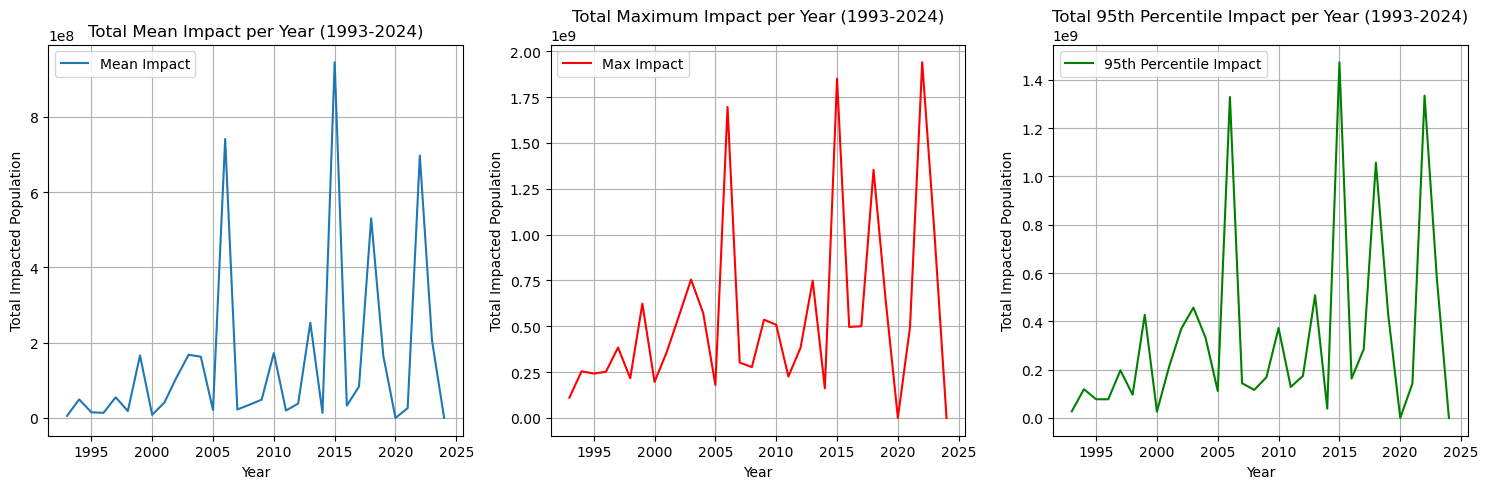

In [38]:
# Plot the mean tropical nights impact per year
years = np.array([datetime.fromordinal(date).year for date in hazard_mean.date])
unique_years = np.unique(years)
annual_impact_mean = np.zeros(unique_years.shape)
for i, year in enumerate(unique_years):
    annual_impact_mean[i] = tn_impact_mean.at_event[years == year].sum()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(unique_years, annual_impact_mean, label='Mean Impact')
plt.xlabel('Year')
plt.ylabel('Total Impacted Population')
plt.title('Total Mean Impact per Year (1993-2024)')
plt.grid(True)
plt.legend()

# Plot the maximum tropical nights impact per year
annual_impact_max = np.zeros(unique_years.shape)
for i, year in enumerate(unique_years):
    annual_impact_max[i] = tn_impact_max.at_event[years == year].sum()

plt.subplot(1, 3, 2)
plt.plot(unique_years, annual_impact_max, color='red', label='Max Impact')
plt.xlabel('Year')
plt.ylabel('Total Impacted Population')
plt.title('Total Maximum Impact per Year (1993-2024)')
plt.grid(True)
plt.legend()

# Plot the 95th percentile tropical nights impact per year
annual_impact_p95 = np.zeros(unique_years.shape)
for i, year in enumerate(unique_years):
    annual_impact_p95[i] = tn_impact_p95.at_event[years == year].sum()

plt.subplot(1, 3, 3)
plt.plot(unique_years, annual_impact_p95, color='green', label='95th Percentile Impact')
plt.xlabel('Year')
plt.ylabel('Total Impacted Population')
plt.title('Total 95th Percentile Impact per Year (1993-2024)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# The total impact over all events and locations using hazard data at 95th percentile
total_sum = tn_impact_p95.imp_mat.sum()
total_sum

10976205200.104324

In [40]:
# The total impact over all events and locations using mean hazard data
total_sum = tn_impact_mean.imp_mat.sum()
total_sum

4858651786.983631

In [41]:
# Calculate the aggregated average annual impact
aai_agg = int(tn_impact_p95.aai_agg)  # total_sum = heat_waves_impact_mean.imp_mat.sum()
print("Aggregated average annual mean impact:", "{:,}".format(aai_agg))

Aggregated average annual mean impact: 10,976,205,200


In [42]:
# Calculate the aggregated average annual mean impact
aai_agg_mean = int(tn_impact_mean.aai_agg)  
print("Aggregated average annual mean impact:", "{:,}".format(aai_agg_mean))

# Calculate the aggregated average annual maximum impact
aai_agg_max = int(tn_impact_max.aai_agg)
print("Aggregated average annual maximum impact:", "{:,}".format(aai_agg_max))

# Calculate the aggregated average annual 95th percentile impact
aai_agg_p95 = int(tn_impact_p95.aai_agg)  # This assumes that tn_impact_p95 also has the aai_agg attribute calculated similarly
print("Aggregated average annual 95th percentile impact:", "{:,}".format(aai_agg_p95))

Aggregated average annual mean impact: 4,858,651,786
Aggregated average annual maximum impact: 17,833,212,261
Aggregated average annual 95th percentile impact: 10,976,205,200


In [68]:
# Access impact per event
event_name_1 = '2006-06-01' # event for June 2006
event_name_2 = '2022-06-01' # event for June 2022

event_06_2006 = hazard_max.event_name.index(event_name_1)  # index of the event for the year 2006
event_06_2022 = hazard_max.event_name.index(event_name_2)  # index of the event for the year 2022

# Calculate the total impact for the year 1985
impact_2006 = round(tn_impact_max.at_event[event_06_2006])
impact_2022 = round(tn_impact_max.at_event[event_06_2022])

eai_2006 = impact_2006
eai_2022 = impact_2022
print(f'Expected impact for the event {event_name_1}: {eai_2006:,} people')
print(f'Expected impact for the event {event_name_2}: {eai_2022:,} people')

Expected impact for the event 2006-06-01: 46,039,046 people
Expected impact for the event 2022-06-01: 95,612,771 people


From section 1.6.1.2, "Visualizing LitPop Exposures," it is indicated that the combined population of Switzerland and Germany, used as the reference population, was 87,159,022 individuals. Now, we will compute the proportion of this reference population that was affected.

In [44]:
# Calculate the percentage of afected population for the event 2022
percentage_change_2022 = ((eai_2022 / total_population) * 100)
print(f'Percentage of afected population at {event_name_2}: {percentage_change_2022:.1f}%')

Percentage of afected population at 2014-08-01: 78.5%


In [45]:
annual_impacts = tn_impact_mean.impact_per_year()
annual_impacts_max = tn_impact_max.impact_per_year()
annual_impacts_p95 = tn_impact_p95.impact_per_year()  
# Convert dictionaries to DataFrames
df_mean = pd.DataFrame(list(annual_impacts.items()), columns=['Year', 'Impact_Mean'])
df_max = pd.DataFrame(list(annual_impacts_max.items()), columns=['Year', 'Impact_Max'])
df_p95 = pd.DataFrame(list(annual_impacts_p95.items()), columns=['Year', 'Impact_P95'])  # DataFrame for 95th percentile impacts

# Merge DataFrames on 'Year'
df_combined = pd.merge(df_mean, df_max, on='Year')
df_combined = pd.merge(df_combined, df_p95, on='Year')  # Adding the 95th percentile data

# Convert impact values to integer and format for better readability
df_combined['Impact_Mean'] = df_combined['Impact_Mean'].astype(int)
df_combined['Impact_Max'] = df_combined['Impact_Max'].astype(int)
df_combined['Impact_P95'] = df_combined['Impact_P95'].astype(int)  

# Format the impact values with commas for thousands
df_combined['Impact_Mean'] = df_combined['Impact_Mean'].apply(lambda x: "{:,}".format(x))
df_combined['Impact_Max'] = df_combined['Impact_Max'].apply(lambda x: "{:,}".format(x))
df_combined['Impact_P95'] = df_combined['Impact_P95'].apply(lambda x: "{:,}".format(x))

# Sort by Year for sequential viewing
df_combined.sort_values(by='Year', inplace=True)

# Print or display the DataFrame
print(df_combined.to_string(index=False))

 Year Impact_Mean    Impact_Max    Impact_P95
 1993   5,460,988   110,522,266    27,070,617
 1994  49,234,083   254,256,837   118,937,112
 1995  14,984,209   242,093,517    77,355,950
 1996  13,594,306   251,641,735    77,163,880
 1997  54,774,954   384,166,879   196,957,724
 1998  18,340,618   216,671,812    96,391,959
 1999 166,047,905   623,406,336   426,795,333
 2000   8,361,937   196,496,736    26,060,846
 2001  40,654,715   358,963,580   211,683,134
 2002 107,620,628   554,853,257   369,251,039
 2003 167,803,705   754,970,701   456,916,796
 2004 162,598,449   571,464,615   331,482,664
 2005  21,348,263   179,631,136   111,638,845
 2006 740,883,705 1,696,331,476 1,328,580,698
 2007  22,441,738   302,219,422   143,597,455
 2008  35,090,573   277,378,083   116,077,060
 2009  48,647,934   535,768,140   168,346,751
 2010 172,404,595   508,174,679   372,004,728
 2011  19,641,326   225,878,039   128,260,014
 2012  38,305,554   382,767,901   174,021,532
 2013 252,699,655   748,535,335   

The **Frequency Curve** below shows the annual probability (frequency) of overshooting a given impact level. It is calculated by sorting the impacts of all events in descending order and plotting them against their rank divided by the 100 years under study. In CLIMADA, you can calculate the exceedance frequency curve using the calc_freq_curve method of the Impact object. 

<Figure size 1000x600 with 0 Axes>

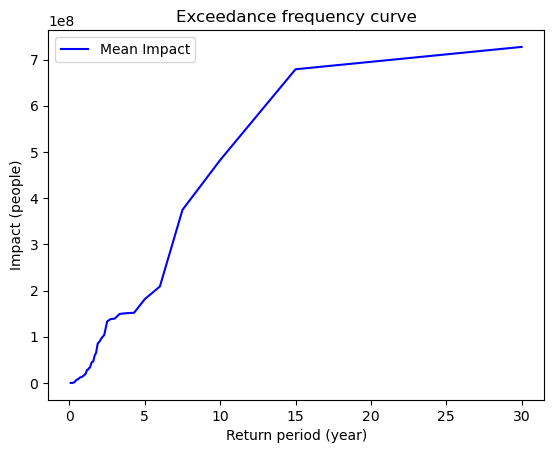

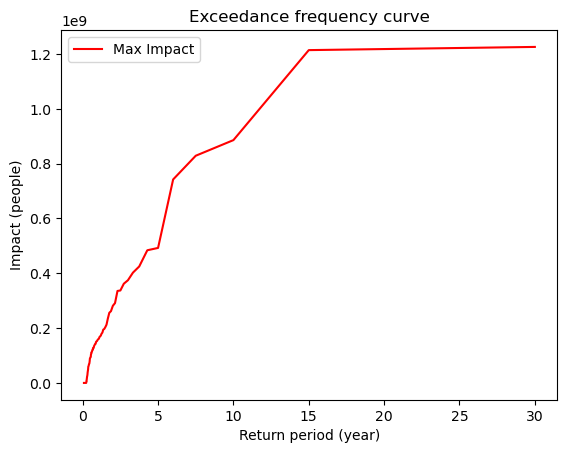

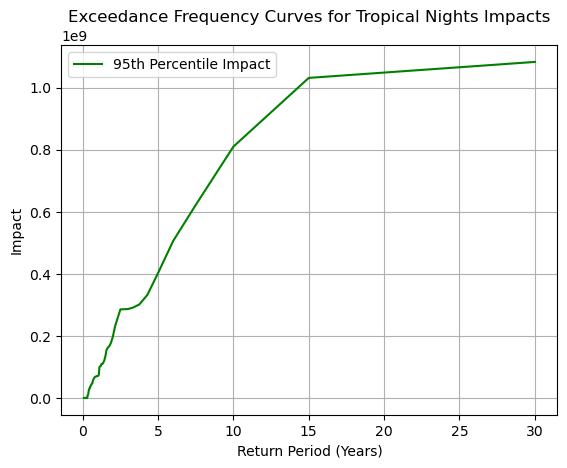

In [46]:
# Compute the exceedance frequency curve for mean impacts
freq_curve_mean = tn_impact_mean.calc_freq_curve()
freq_curve_mean.return_per = freq_curve_mean.return_per * 30  # Adjust return period scale if necessary
plt.figure(figsize=(10, 6))
freq_curve_mean.plot(label='Mean Impact', color='blue')
plt.legend()

# Compute the exceedance frequency curve for maximum impacts
freq_curve_max = tn_impact_max.calc_freq_curve()
freq_curve_max.return_per = freq_curve_max.return_per * 30
freq_curve_max.plot(label='Max Impact', color='red')
plt.legend()

# Compute the exceedance frequency curve for 95th percentile impacts
freq_curve_p95 = tn_impact_p95.calc_freq_curve()
freq_curve_p95.return_per = freq_curve_p95.return_per * 30
freq_curve_p95.plot(label='95th Percentile Impact', color='green')
plt.legend()

# Enhance the plot with labels and legend
plt.title('Exceedance Frequency Curves for Tropical Nights Impacts')
plt.xlabel('Return Period (Years)')
plt.ylabel('Impact')
plt.grid(True)
plt.show()

Here we are examining the expected impact calculated with the mean value of tropical nights hazard

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')

Text(0.5, 1.0, 'Expected Impact (2009-08-01 to 2010-03-01)')

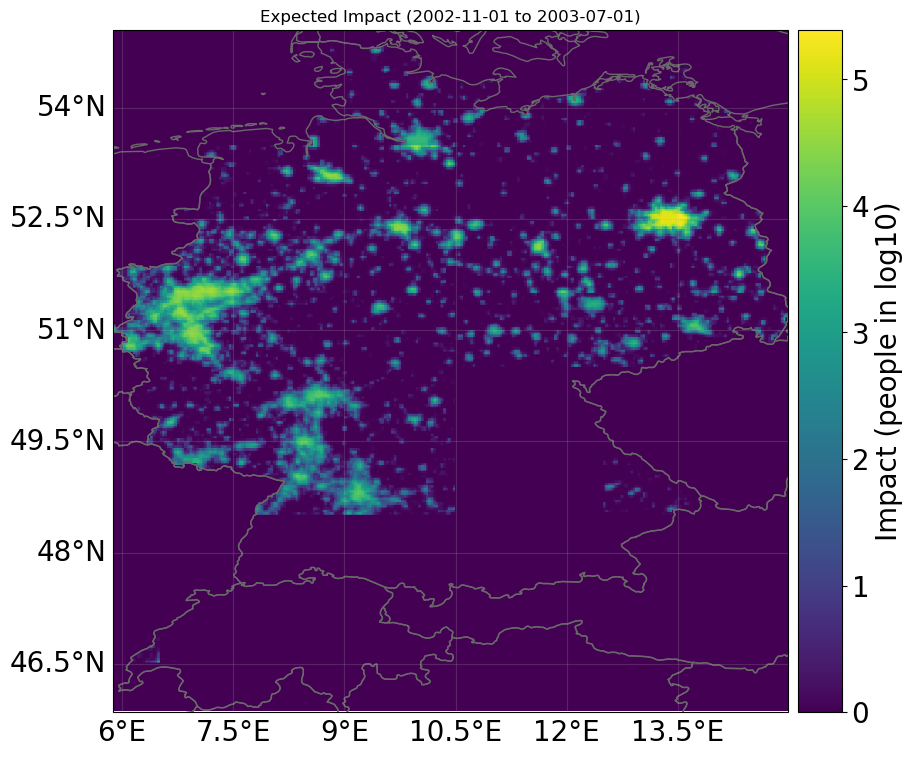

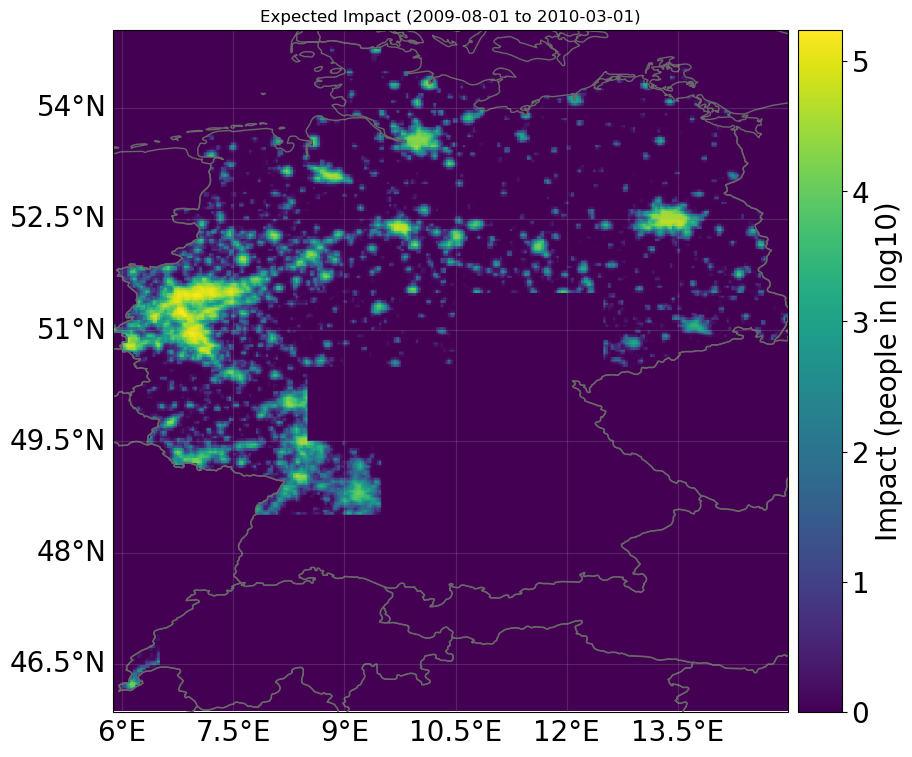

In [47]:
# Example 1: Event names from hazard_max dataset (for events 118 to 127)
event_names_118_127 = [hazard_max.event_name[i] for i in range(118, 127)]

# Select impacts for these events with reset_frequency=True
selected_imp_118_127 = tn_impact_mean.select(event_names=event_names_118_127)
ax = selected_imp_118_127.plot_raster_eai_exposure(label="Impact (people in log10)")
ax.set_title(f"Expected Impact ({event_names_118_127[0]} to {event_names_118_127[-1]})")

# Example 2: Event names from hazard_max dataset (for events 199 to 207)
event_names_199_207 = [hazard_max.event_name[i] for i in range(199, 207)]

# Select impacts for these events with reset_frequency=True
selected_imp_199_207 = tn_impact_mean.select(event_names=event_names_199_207)
ax = selected_imp_199_207.plot_raster_eai_exposure(label="Impact (people in log10)")
ax.set_title(f"Expected Impact ({event_names_199_207[0]} to {event_names_199_207[-1]})")

Here we are examining the expected impact calculated with the 95th percentile of tropical nights hazard

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')

Text(0.5, 1.0, 'Expected Impact (2014-02-01 to 2014-09-01)')

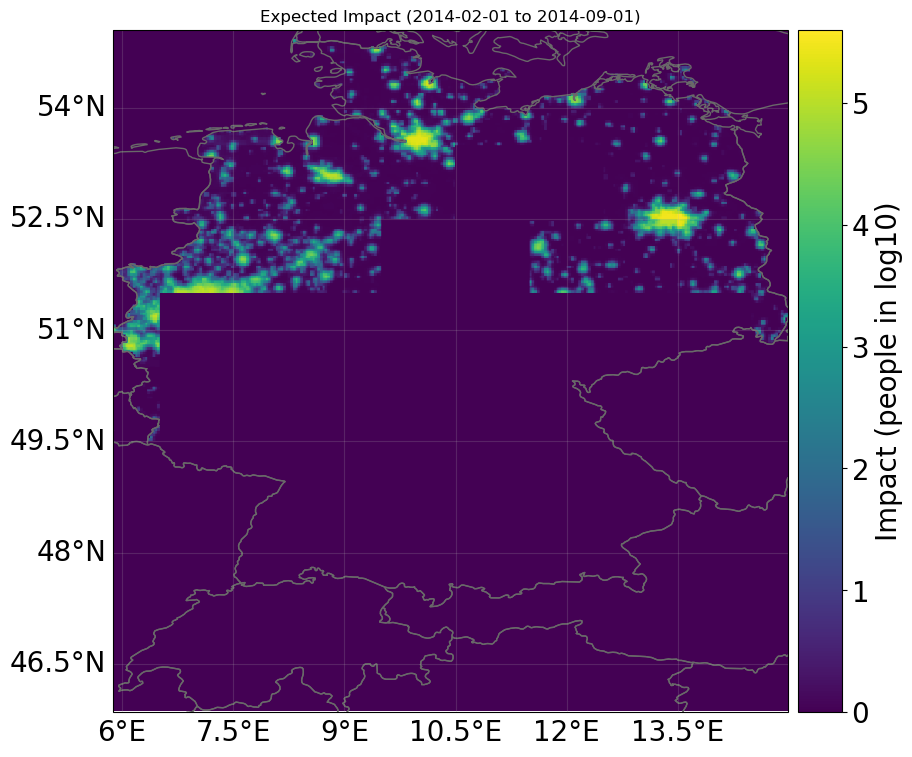

In [48]:
# Define the event names from the hazard_max dataset
event_names = [hazard_max.event_name[i] for i in range(253, 261)]

# Select impacts for these events with reset_frequency=True
select_imp = tn_impact_p95.select(event_names=event_names)

ax = select_imp.plot_raster_eai_exposure(label="Impact (people in log10)")
ax.set_title(f"Expected Impact ({event_names[0]} to {event_names[-1]})")

In [49]:
select_imp.imp_mat.sum(axis=0).max()

398765.78762852197

In [50]:
select_imp.imp_mat.sum(axis=0)

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.55235381,
         20.63445704,  0.21310799]])

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')

Text(0.5, 1.0, 'Expected Impact (2002-11-01 to 2003-07-01)')

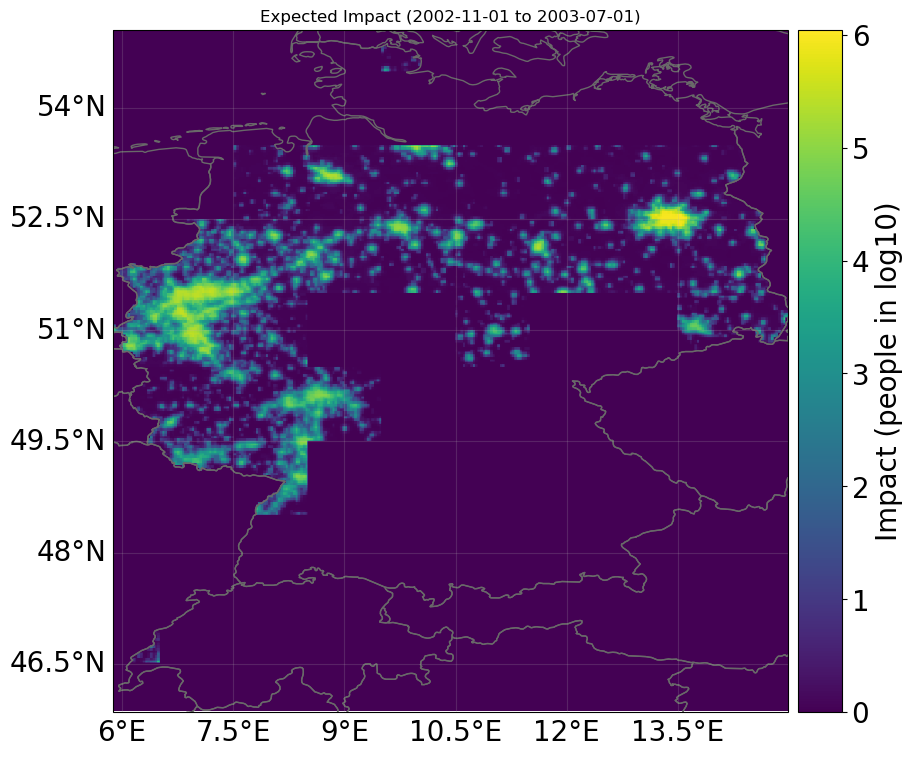

In [51]:
# Define the event names from the hazard_max dataset
event_names = [hazard_max.event_name[i] for i in range(118, 127)]

# Select impacts for these events with reset_frequency=True
select_imp = tn_impact_p95.select(event_names=event_names)

ax = select_imp.plot_raster_eai_exposure(label="Impact (people in log10)")
ax.set_title(f"Expected Impact ({event_names[0]} to {event_names[-1]})")

<GeoAxes: title={'center': 'Expected annual impact'}>

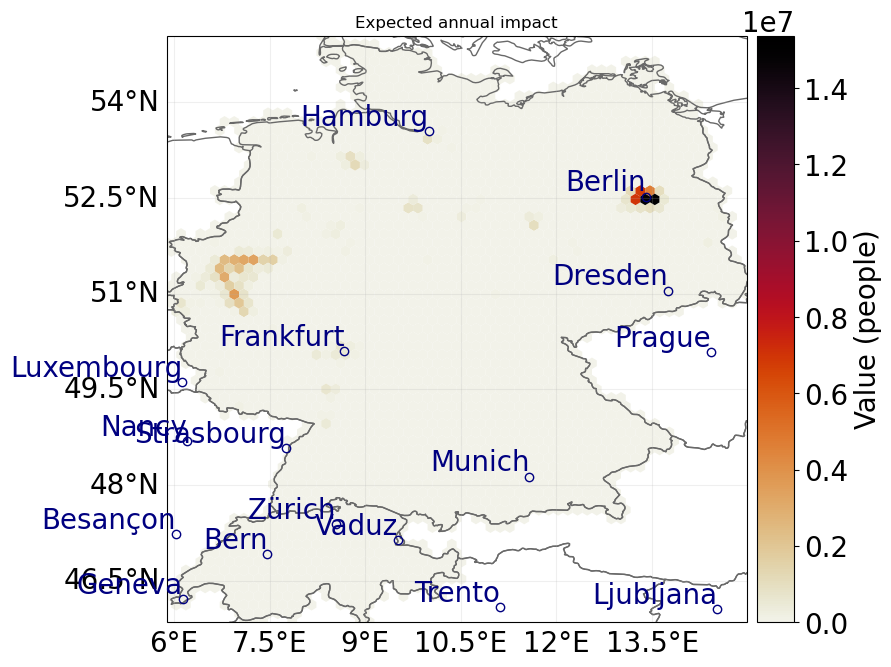

In [52]:
select_imp.plot_hexbin_eai_exposure(gridsize=60, linewidths=0)

#### Visualize Impact 

We will visualise the impact through **Expected Annual Impact (EAI)**. AEI is the expected impact **in an average year, for each exposure point**, based on data from the 54 months under study. It is the sum of the impacts of all events, each multiplied by its frequency (the number of times it occurs per year), divided by the number of months in the study period. This metric is especially useful when seeking an overview of the average impact over time, offering a broader perspective that highlights areas more consistently affected by the hazard in question.

Below, we present different outputs to showcase the results:

**plot_hexbin_eai_exposure():**

Hexbin: This method employs hexagonal binning for visualization. Hex binning divides a map into hexagonal intervals, aggregating the data within each interval. Each hexagon's color represents the aggregated value of the data it contains. This approach is particularly useful for visualizing data in areas with a high density of data points, as it prevents overplotting and highlights patterns more effectively.

**plot_raster_eai_exposure():**

Raster: In geospatial analysis, a raster is a fundamental data format based on resizable grids where each cell or pixel holds a value. In this visualization, each cell is colored based on the average population affected by heat waves. The results are displayed on a logarithmic scale.

These plots can be modified according to the user's needs. For more information, please refer to the following [documentation](https://shorturl.at/pqCO0).

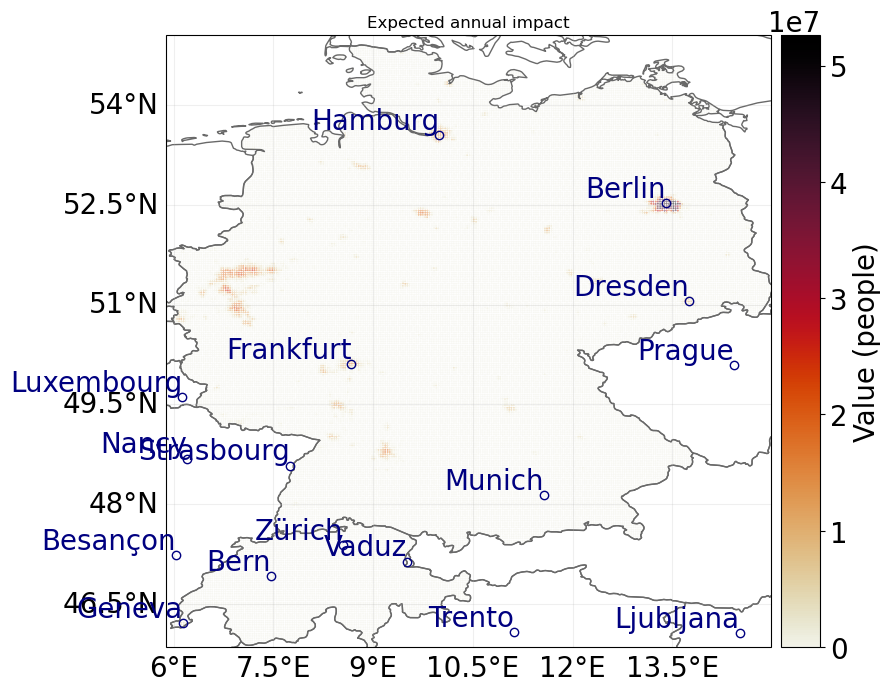

In [53]:
# Plot the expected annual impact (EAI) with plot_hexbin_eai_exposure

eai_heat_waves_impact_mean = tn_impact_p95.plot_hexbin_eai_exposure(adapt_fontsize=True)

# Save the plot as an image
filename = f'{DATADIR}/eai_tn_impact_p95_all_hincast_years_hexbin.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')

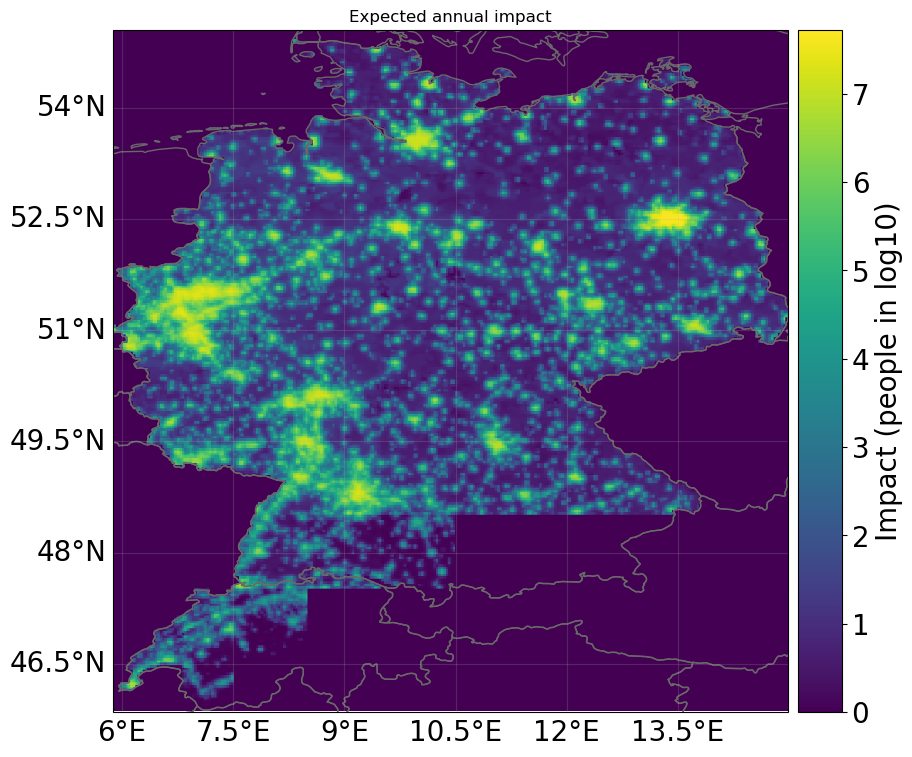

In [54]:
# Plot the expected annual impact (EAI) with plot_raster_eai_exposure()

tn_impact_p95.plot_raster_eai_exposure(label="Impact (people in log10)")

# Save the plot as an image
filename = f'{DATADIR}/eai_tn_impact_p95_all_hincast_years_raster.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

Another visualization tool available is the **plot_basemap_impact_exposure()** function. It offers a geographical depiction of both the impact of a hazard event and the exposure of various assets or populations to that event. This map allows users to quickly identify areas of high impact and high exposure, which are essential for making informed decisions in climate adaptation and risk management. It is particularly useful when aiming to understand the impact of a specific event on various exposures. This result can also be deployed as hexbin **plot_hexbin_impact_exposure**.

### Evaluating Vulnerability Metrics for Targeted Urban Areas (Point Data)

We can also calculate the impact for specific cities. To do this, we use the coordinates of the cities to generate the centroids that enable impact estimation. We then plot the "Impact Exceedance Frequency Curve" to compare and learn how frequently the impact of heat waves exceeds a certain threshold, affecting the population in these areas. For this analysis, we have chosen seven cities: Berlin, Zurich, Munich, Geneva, Hamburg, Bonn, and Stuttgart.

> **Note**: The "Impact Exceedance Frequency Curve" graphically depicts risk by showing how often certain impact levels are surpassed. The Y-axis represents impact levels, while the X-axis shows return periods, which indicate the average time between significant impacts. The curve is calculated by dividing the number of events exceeding a given impact by the total events. For instance, if an impact level is exceeded 10 times in 100 years, the exceedance frequency is 0.1 per year.

> **Tip**: To interpret the curve, keep these key aspects in mind:

   > - A point on the curve shows that the impact level on the Y-axis is exceeded with a frequency indicated on the X-axis.
   > - A descending curve signifies that higher impact levels occur less frequently.
   > - The curve aids in risk assessment by displaying the likelihood of various impact levels.

2025-01-04 16:36:42,426 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,429 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,445 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,456 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,472 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,488 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-01-04 16:36:42,504 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


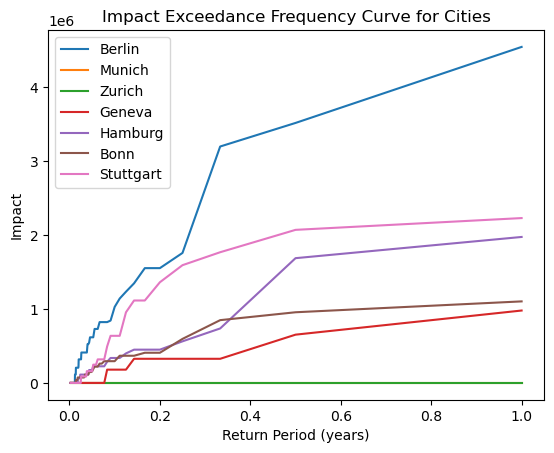

In [56]:
from climada.entity import Exposures
from geopy.distance import great_circle

# Define coordinates of the 5 cities (latitude, longitude)
cities_coords = {
    'Berlin': [52.5200, 13.4050],
    'Munich': [48.1351, 11.5820],
    'Zurich': [47.3769, 8.5417],
    'Geneva': [46.2044, 6.1432],
    'Hamburg': [53.5511, 9.9937],
    'Bonn': [50.7374, 7.0982],       # Coordinates of Bonn
    'Stuttgart': [48.7758, 9.1829]   # Coordinates of Stuttgart
}


# Initialize a dictionary to store impact objects for each city
city_impacts = {}

# Loop through each city to calculate its impact
for city, coords in cities_coords.items():
    lat, lon = coords
    
    # Find the closest centroid to the city coordinates
    distance_to_target = np.sqrt((exposure.gdf.latitude - lat)**2 + (exposure.gdf.longitude - lon)**2)
    closest_idx = distance_to_target.idxmin()
    
    # Create a new exposure object containing only this centroid
    exposure_city = Exposures(exposure.gdf.loc[[closest_idx]])
    
    # Assign the centroids of hazard events to the new exposure data
    exposure_city.assign_centroids(hazard_p95)
    
    # Calculate the impact for this city
    impact = Impact()
    impact.calc(exposure_city, if_set, hazard_p95)
    
    # Store the impact object in the dictionary
    city_impacts[city] = impact

# Initialize a plot for frequency curves
fig, ax = plt.subplots()

# Loop through each city to plot its frequency curve
for city, impact in city_impacts.items():
    impact.calc_freq_curve().plot(axis=ax, label=city)

# Customize the plot
ax.set_title('Impact Exceedance Frequency Curve for Cities')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Impact')
ax.legend()

# Show the plot
plt.show()

### Write a NetCDF

In [57]:
from ImpactWriteReadNetCDF import ImpactWriteNetCDF, ImpactReaderNetCDF

In [58]:
# Save the impact data to a NetCDF file
visualizer = ImpactWriteNetCDF(tn_impact_p95)
filename = f'{DATADIR}/tn_impact_p95_all_years.nc'
visualizer.write_to_netcdf(filename)

### Read NetCDF file

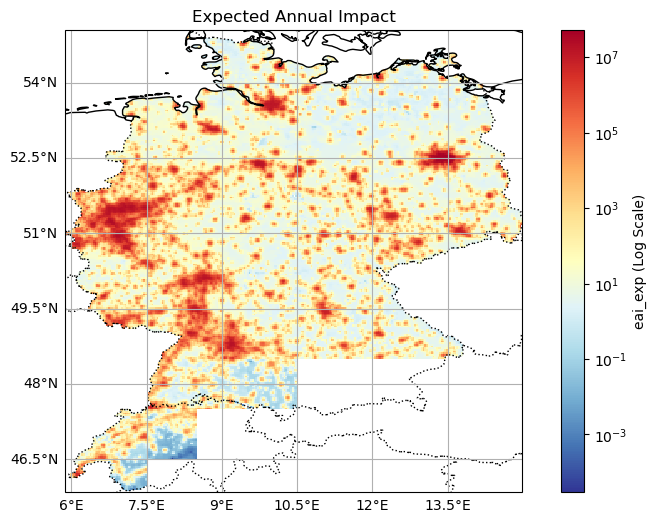

In [59]:
# Read NetCDF file
filename = f'{DATADIR}/tn_impact_p95_all_years.nc'
reader = ImpactReaderNetCDF(filename)
reader.read_netcdf()
reader.visualize(scale='log')  # Use "log" for logarithmic scale, and "normal" for normal scale

### Write GeoTIFF File

In [60]:
from impactWriteReadGeoTIFF import ImpactWriteGeoTIFF, ImpactReaderGeoTIFF

In [61]:
# Save the impact data to a GeoTIFF file
visualizer = ImpactWriteGeoTIFF(tn_impact_p95)
filename = f'{DATADIR}/tn_impact_p95_all_years.tif'
visualizer.write_to_geotiff(filename)

### Read GeoTIFF File

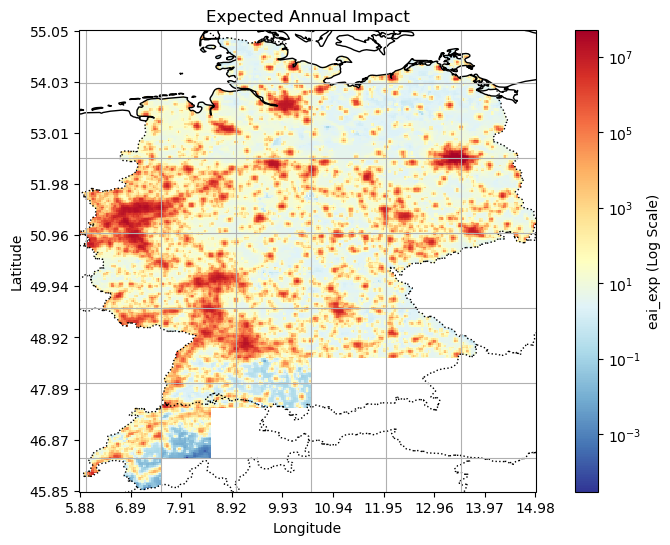

In [62]:
# Read GeoTIFF file
filename = f'{DATADIR}/tn_impact_p95_all_years.tif'
visualizer = ImpactReaderGeoTIFF(filename)
visualizer.plot_geotiff(scale='log')  # For logarithmic scale